New iteration of the River Pollution analysis. With changes to how the districts and station codes are calculated.

Sample selection goal: Select all the districts lying on the river Ganga, and map them to one of the station codes for all the years. Use the min distance objective function and calculate a list of nearsest station codes. Upto 5 nearest. 

<p>Step0: Define sample to be all districts lying on the bank of Ganga and its tributaries
<p>Step1: For each district in the sample, calculate the distances from its centroid to all stations
<p>Note: All stations are all unique stations across years
<p>Step2: Identify the 1st, 2nd, 3rd, 4th, 5th closest stations to each district
<p>Step3: For each year, assign the pollution data of the closest station to the district

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as plotly
import folium as fl
import geopandas as gpd

from gadm import GADMDownloader
from shapely.geometry import Point
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import geopy.distance



/Users/arjunarora/opt/miniconda3/envs/fdps/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
#Get the list of all districts adjacent to river Ganga
ganga_districts = pd.read_csv("/Users/arjunarora/Desktop/River pollution/Data/Pollution/ganga_districts.csv")
ganga_districts.drop(columns='Sr. No', inplace=True)
ganga_districts.shape

(139, 2)

In [4]:
ganga_districts_distinct = ganga_districts.groupby(by=['District']).mean().reset_index()

/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_3776/1189211754.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ganga_districts_distinct = ganga_districts.groupby(by=['District']).mean().reset_index()


In [5]:
ganga_districts_distinct

,District
0,Agra
1,Aligarh
2,Allahabad
3,Ambedkarnagar
4,Amethi
...,...
124,Uttarkashi
125,Vaishali
126,Varanasi
127,West Champaran


In [6]:
#ganga_districts_distinct.to_csv("ganga_districts_distinct.csv")

In [7]:
ganga_districts_distinct = pd.read_csv("/Users/arjunarora/Desktop/River pollution/Data/Pollution/ganga_districts_distinct.csv")

In [8]:
ganga_districts_distinct['District'].nunique()

122

In [9]:
ganga_districts_distinct.shape

(122, 2)

In [10]:
#Add longitude and latitude information to ganga_districts dataframe. 

downloader = GADMDownloader(version="4.0")

country_name = "India"
ad_level = 2
gdf = downloader.get_shape_data_by_country_name(country_name=country_name, ad_level=ad_level)
gdf['district_centroid'] = [x.centroid for x in gdf['geometry']]

gdf['centroid'] = gdf['district_centroid'].apply(lambda x: x.centroid if x else None)

# Extract the latitude and longitude values from the centroids
gdf['latitude'] = gdf['centroid'].apply(lambda x: x.y if x else None)
gdf['longitude'] = gdf['centroid'].apply(lambda x: x.x if x else None)

# Drop the temporary 'centroid' column
gdf.drop('centroid', axis=1, inplace=True)


In [11]:
gdf.head()

,ID_0,COUNTRY,NAME_1,NL_NAME_1,ID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,district_centroid,latitude,longitude
0,IND,India,Andaman and Nicobar,,IND.1.1_1,Nicobar Islands,,,District,District,,IN.AN.NI,"MULTIPOLYGON (((93.78988 6.85201, 93.79015 6.8...",POINT (93.5990937324446 7.525464207876377),7.525464,93.599094
1,IND,India,Andaman and Nicobar,,IND.1.2_1,North and Middle Andaman,,,District,District,,IN.AN.NM,"MULTIPOLYGON (((92.84441 12.14969, 92.84466 12...",POINT (92.87285895866384 12.852938105665313),12.852938,92.872859
2,IND,India,Andaman and Nicobar,,IND.1.3_1,South Andaman,,,District,District,,IN.AN.SA,"MULTIPOLYGON (((92.52111 10.89694, 92.52306 10...",POINT (92.66512393781024 11.528110355441923),11.528110,92.665124
3,IND,India,Andhra Pradesh,,IND.2.1_1,Anantapur,"Anantpur, Ananthapur",,District,District,,IN.AD.AN,"MULTIPOLYGON (((77.84600 13.92832, 77.83012 13...",POINT (77.57084647774622 14.475092112716293),14.475092,77.570846
4,IND,India,Andhra Pradesh,,IND.2.2_1,Chittoor,Chitoor|Chittor,,District,District,,IN.AD.CH,"MULTIPOLYGON (((78.54555 12.74391, 78.55031 12...",POINT (79.00393766085182 13.456597359374607),13.456597,79.003938


In [12]:
ganga_states = ['Uttarakhand','Uttar Pradesh','Bihar', 'Jharkhand','West Bengal', 'NCT of Delhi', 'Chhattisgarh', 'Haryana']
gdf_ganga_states = gdf.loc[gdf['NAME_1'].isin(ganga_states)]

In [13]:
# Define a function for fuzzy matching
def fuzzy_matching(district_name, choices):
    match = process.extractOne(district_name, choices)
    if match[1] >= 90:  # Set a threshold for similarity score
        return match[0]
    else:
        return None
# Assuming you have two dataframes: ganga_districts_df and gdf
# ganga_districts_df contains the district names from Ganga districts
# gdf contains the districts from the whole country

# Apply fuzzy matching to find the similar district names in gdf for each district in ganga_districts_df
ganga_districts_distinct['matched_district_name'] = ganga_districts_distinct['District'].apply(
    lambda x: fuzzy_matching(x, gdf_ganga_states['NAME_2'].unique())
)



In [14]:
ganga_districts_distinct

,Unnamed: 0,District,matched_district_name
0,0,Agra,Agra
1,1,Aligarh,Aligarh
2,2,Allahabad,Allahabad
3,3,Ambedkarnagar,Ambedkar Nagar
4,4,Amethi,Amethi
...,...,...,...
117,123,Unnao,Unnao
118,124,Uttarkashi,Uttarkashi
119,125,Vaishali,Vaishali
120,126,Varanasi,Varanasi


In [15]:
ganga_districts_distinct.to_csv("ganga_districts_matched.csv")

In [16]:
ganga_districts_matched  = pd.read_csv("/Users/arjunarora/Desktop/River pollution/Data/Pollution/ganga_districts_matched.csv")

In [17]:
ganga_districts_matched

,Unnamed: 0,District,matched_district_name
0,0,Agra,Agra
1,1,Aligarh,Aligarh
2,2,Allahabad,Allahabad
3,3,Ambedkarnagar,Ambedkar Nagar
4,4,Amethi,Amethi
...,...,...,...
117,117,Unnao,Unnao
118,118,Uttarkashi,Uttarkashi
119,119,Vaishali,Vaishali
120,120,Varanasi,Varanasi


In [18]:
ganga_districts_coordinates = ganga_districts_matched.merge(gdf_ganga_states, how='left', left_on='matched_district_name', right_on='NAME_2')
ganga_districts_coordinates

,Unnamed: 0,District,matched_district_name,ID_0,COUNTRY,NAME_1,NL_NAME_1,ID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,district_centroid,latitude,longitude
0,0,Agra,Agra,IND,India,Uttar Pradesh,,IND.34.1_1,Agra,,,District,District,,IN.UP.AG,"MULTIPOLYGON (((78.76215 26.76683, 78.75448 26...",POINT (78.06292448694016 27.00750514448138),27.007505,78.062924
1,1,Aligarh,Aligarh,IND,India,Uttar Pradesh,,IND.34.2_1,Aligarh,,,District,District,,IN.UP.AL,"MULTIPOLYGON (((78.02922 27.77695, 78.02602 27...",POINT (78.0771821412473 27.926165556871766),27.926166,78.077182
2,2,Allahabad,Allahabad,IND,India,Uttar Pradesh,,IND.34.3_1,Allahabad,,,District,District,,IN.UP.AH,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),25.299889,81.964809
3,3,Ambedkarnagar,Ambedkar Nagar,IND,India,Uttar Pradesh,,IND.34.4_1,Ambedkar Nagar,,,District,District,,IN.UP.AN,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852),26.423723,82.659826
4,4,Amethi,Amethi,IND,India,Uttar Pradesh,,IND.34.5_1,Amethi,,,District,District,,,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971),26.286784,81.630814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,117,Unnao,Unnao,IND,India,Uttar Pradesh,,IND.34.74_1,Unnao,"Unnao Nagar, Unao",,District,District,,IN.UP.UN,"MULTIPOLYGON (((80.65694 26.13872, 80.65340 26...",POINT (80.54996016514015 26.6143397673387),26.614340,80.549960
119,118,Uttarkashi,Uttarkashi,IND,India,Uttarakhand,,IND.35.13_1,Uttarkashi,,,District,District,,IN.UT.UT,"MULTIPOLYGON (((78.58400 30.67935, 78.58540 30...",POINT (78.58951654754148 30.9783506463683),30.978351,78.589517
120,119,Vaishali,Vaishali,IND,India,Bihar,,IND.5.38_1,Vaishali,,,District,District,,IN.BR.VA,"MULTIPOLYGON (((85.41669 25.94031, 85.42208 25...",POINT (85.3620254879767 25.763019030177777),25.763019,85.362025
121,120,Varanasi,Varanasi,IND,India,Uttar Pradesh,,IND.34.75_1,Varanasi,Benares,,District,District,,IN.UP.VA,"MULTIPOLYGON (((83.17112 25.51279, 83.16818 25...",POINT (82.90902975267382 25.39063107192604),25.390631,82.909030


In [22]:
ganga_districts_coordinates.loc[ganga_districts_coordinates['District'] == 'Balrampur']

,Unnamed: 0,District,matched_district_name,ID_0,COUNTRY,NAME_1,NL_NAME_1,ID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,district_centroid,latitude,longitude
14,13,Balrampur,Balrampur,IND,India,Uttar Pradesh,,IND.34.12_1,Balrampur,,,District,District,,IN.UP.BP,"MULTIPOLYGON (((82.73704 27.50454, 82.73570 27...",POINT (82.36882358476893 27.48714704416788),27.487147,82.368824


In [20]:

ganga_districts_coordinates.drop_duplicates(subset='Unnamed: 0', keep='last', inplace=True)


In [21]:
ganga_districts_coordinates.columns

Index(['Unnamed: 0', 'District', 'matched_district_name', 'ID_0', 'COUNTRY',
       'NAME_1', 'NL_NAME_1', 'ID_2', 'NAME_2', 'VARNAME_2', 'NL_NAME_2',
       'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2', 'geometry',
       'district_centroid', 'latitude', 'longitude'],
      dtype='object')

In [23]:
imp_cols = ['District', 'matched_district_name', 'NAME_1', 'NAME_2', 'latitude', 'longitude', 'geometry', 'district_centroid']

In [24]:
ganga_districts_coordinates_imp = ganga_districts_coordinates[imp_cols]

In [25]:
ganga_districts_coordinates_imp.head()

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid
0,Agra,Agra,Uttar Pradesh,Agra,27.007505,78.062924,"MULTIPOLYGON (((78.76215 26.76683, 78.75448 26...",POINT (78.06292448694016 27.00750514448138)
1,Aligarh,Aligarh,Uttar Pradesh,Aligarh,27.926166,78.077182,"MULTIPOLYGON (((78.02922 27.77695, 78.02602 27...",POINT (78.0771821412473 27.926165556871766)
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403)
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852)
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971)


In [26]:
water_quality_station_codes = pd.read_excel("/Users/arjunarora/Desktop/River pollution/Data/Pollution/WQMN_list(3).xlsx")

In [27]:
water_quality_station_codes

,Water\nQuality Station Code,Name or Location of Monitoring Station,Unnamed: 2,Unnamed: 3,State/UT,Type of Water Body,Frequency of Monitoring,Latitude,Longitude
0,14,"GODAVARI AT POLAVARAM, WEST GODAVARI DISTRICT",NaN,NaN,ANDHRA PRADESH,RIVER,MONTHLY,17.247331,81.646613
1,25,"KRISHNA AT VIJAYWADA, KRISHNA",NaN,NaN,ANDHRA PRADESH,RIVER,MONTHLY,16.492476,80.640839
2,26,"WELL AT GRAM PANCHAYAT OFFICE, KAANURU, VIJAYWADA",NaN,NaN,ANDHRA PRADESH,GROUND WATER,HALF-YEARLY,16.508853,80.641519
3,30,"PENNAR AT SIDDVATAM, KADAPA",NaN,NaN,ANDHRA PRADESH,RIVER,MONTHLY,14.464393,78.964627
4,1174,"TUNGABHADRA AT KURNOOL U/S, BHAVAPURAM, KURNOOL",NaN,NaN,ANDHRA PRADESH,RIVER,MONTHLY,15.848300,78.034942
...,...,...,...,...,...,...,...,...,...
4106,10160,"RIVER GANGA AT BEHRAMPORE, (GORA BAZAR),MURSHI...",NaN,NaN,WEST BENGAL,RIVER,MONTHLY,24.101003,88.243238
4107,10161,"RIVER GANGA AT PALTA, SHITALTALA,",NaN,NaN,WEST BENGAL,RIVER,MONTHLY,22.774972,88.334278
4108,30064,CHURNI AT BIJOYPUR (WEST BENGAL),NaN,NaN,WEST BENGAL,RIVER,UARTERLY (INTERSTAT,23.324276,88.584259
4109,30065,DAMODAR AT DISHERGARH (WEST BENGAL),NaN,NaN,WEST BENGAL,RIVER,UARTERLY (INTERSTAT,23.685334,86.823224


In [540]:
"""
# Function to calculate distance between two coordinates
def calculate_distance(coord1, coord2):
    return geopy.distance.geodesic(coord1, coord2).kilometers

# Calculate the distance between each district and all water quality stations
distances = []
for _, district in ganga_districts_coordinates_imp.iterrows():
    district_coords = (district['latitude'], district['longitude'])
    station_distances = []
    for _, station in water_quality_station_codes.iterrows():
        station_coords = (station['Latitude'], station['Longitude'])
        distance = calculate_distance(district_coords, station_coords)
        station_distances.append(distance)
    distances.append(station_distances)

# Find the nearest station for each district based on the minimum distance
nearest_stations = [water_quality_station_codes['Water\nQuality Station Code'][d.index(min(d))] for d in distances]

# Create new columns in the district dataframe to store information from the nearest stations
ganga_districts_coordinates_imp['Nearest_Station'] = nearest_stations
ganga_districts_coordinates_imp['Distance_to_Nearest_Station'] = [min(d) for d in distances]
"""

"\n# Function to calculate distance between two coordinates\ndef calculate_distance(coord1, coord2):\n    return geopy.distance.geodesic(coord1, coord2).kilometers\n\n# Calculate the distance between each district and all water quality stations\ndistances = []\nfor _, district in ganga_districts_coordinates_imp.iterrows():\n    district_coords = (district['latitude'], district['longitude'])\n    station_distances = []\n    for _, station in water_quality_station_codes.iterrows():\n        station_coords = (station['Latitude'], station['Longitude'])\n        distance = calculate_distance(district_coords, station_coords)\n        station_distances.append(distance)\n    distances.append(station_distances)\n\n# Find the nearest station for each district based on the minimum distance\nnearest_stations = [water_quality_station_codes['Water\nQuality Station Code'][d.index(min(d))] for d in distances]\n\n# Create new columns in the district dataframe to store information from the nearest stati

In [28]:

# Function to calculate distance between two coordinates
def calculate_distance(coord1, coord2):
    return geopy.distance.geodesic(coord1, coord2).kilometers

# Function to get the nearest stations
def get_nearest_stations(distances_df, n=5):
    nearest_stations = []
    for row in distances_df.iterrows():
        _, distances = row
        sorted_distances = distances.sort_values(ascending=True)
        nearest_stations.append(list(sorted_distances.index[:n]))
    return nearest_stations

# Calculate the distance between each district and all water quality stations
distances = []
for _, district in ganga_districts_coordinates_imp.iterrows():
    district_coords = (district['latitude'], district['longitude'])
    station_distances = []
    for _, station in water_quality_station_codes.iterrows():
        station_coords = (station['Latitude'], station['Longitude'])
        distance = calculate_distance(district_coords, station_coords)
        station_distances.append(distance)
    distances.append(station_distances)

# Create a DataFrame to store the distances
distances_df = pd.DataFrame(distances, columns=water_quality_station_codes['Water\nQuality Station Code'])
distances_df.index = ganga_districts_coordinates_imp.index  # Set the correct row labels

# Get the nearest stations
nearest_stations = get_nearest_stations(distances_df, n=5)

# Create new columns in the district dataframe to store information from the nearest stations
for i in range(5):
    ganga_districts_coordinates_imp[f'{i+1}_Closest_Station'] = [station_list[i] for station_list in nearest_stations]
    ganga_districts_coordinates_imp[f'{i+1}_Distance'] = distances_df.lookup(ganga_districts_coordinates_imp.index, ganga_districts_coordinates_imp[f'{i+1}_Closest_Station'])


/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_3776/955332123.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ganga_districts_coordinates_imp[f'{i+1}_Closest_Station'] = [station_list[i] for station_list in nearest_stations]
/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_3776/955332123.py:35: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  ganga_districts_coordinates_imp[f'{i+1}_Distance'] = distances_df.lookup(ganga_districts_coordinates_imp.index, ganga_districts_coordinates_imp[f'{i+1}_Closest_Station'])
/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_3776/955332123.py:35: SettingWithCopyWarning: 
A 

In [29]:
ganga_districts_coordinates_imp

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,1_Closest_Station,1_Distance,2_Closest_Station,2_Distance,3_Closest_Station,3_Distance,4_Closest_Station,4_Distance,5_Closest_Station,5_Distance
0,Agra,Agra,Uttar Pradesh,Agra,27.007505,78.062924,"MULTIPOLYGON (((78.76215 26.76683, 78.75448 26...",POINT (78.06292448694016 27.00750514448138),1126,19.888379,1125,33.528956,1609,41.542522,4769,41.622568,1498,48.442647
1,Aligarh,Aligarh,Uttar Pradesh,Aligarh,27.926166,78.077182,"MULTIPOLYGON (((78.02922 27.77695, 78.02602 27...",POINT (78.0771821412473 27.926165556871766),1145,42.831563,2489,45.580601,2488,52.137746,2495,53.194217,30031,53.220236
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),2469,12.458084,10158,14.001030,1049,14.716658,2487,17.688017,1069,18.580875
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852),10096,54.576245,1354,59.255898,10095,61.036362,1746,61.194230,10091,72.487835
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971),2499,38.559150,10088,39.473898,10095,43.542390,1746,44.207623,10087,45.809214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,Unnao,Unnao,Uttar Pradesh,Unnao,26.614340,80.549960,"MULTIPOLYGON (((80.65694 26.13872, 80.65340 26...",POINT (80.54996016514015 26.6143397673387),1740,10.138698,1739,10.435228,1738,10.567064,1741,10.586057,10155,23.262533
119,Uttarkashi,Uttarkashi,Uttarakhand,Uttarkashi,30.978351,78.589517,"MULTIPOLYGON (((78.58400 30.67935, 78.58540 30...",POINT (78.58951654754148 30.9783506463683),1491,10.112891,1492,14.416748,1493,18.787914,2612,50.805150,3872,67.580249
120,Vaishali,Vaishali,Bihar,Vaishali,25.763019,85.362025,"MULTIPOLYGON (((85.41669 25.94031, 85.42208 25...",POINT (85.3620254879767 25.763019030177777),2600,8.802316,10163,18.446414,10126,19.229575,1078,19.825457,1079,22.905276
121,Varanasi,Varanasi,Uttar Pradesh,Varanasi,25.390631,82.909030,"MULTIPOLYGON (((83.17112 25.51279, 83.16818 25...",POINT (82.90902975267382 25.39063107192604),2482,5.692258,1758,10.378756,2467,11.094646,10143,13.799013,1071,14.838397


In [30]:
ganga_districts_coordinates_imp.shape

(122, 18)

In [31]:
ganga_districts_coordinates_imp['1_Closest_Station'].nunique()

108

In [402]:
#ganga_districts_coordinates_imp.to_csv("ganga_districts_coordinates_imp_2.csv")

In [404]:
#districts_matching_df = pd.read_csv("Pollution/district_matching_WQMN_gdf.csv")

In [405]:
#districts_matching_df.head()

,District,matched_district_name
0,Agra,Agra
1,Aligarh,Aligarh
2,Allahabad,Allahabad
3,Ambedkarnagar,Ambedkar Nagar
4,Amethi,Amethi


In [406]:
#ganga_districts_coordinates_imp['District'] = districts_matching_df['District']
#ganga_districts_coordinates_imp['matched_district_name'] = districts_matching_df['matched_district_name']


In [33]:
ganga_districts_coordinates_imp.loc[ganga_districts_coordinates_imp['District'] == 'Allahabad']

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,1_Closest_Station,1_Distance,2_Closest_Station,2_Distance,3_Closest_Station,3_Distance,4_Closest_Station,4_Distance,5_Closest_Station,5_Distance
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),2469,12.458084,10158,14.00103,1049,14.716658,2487,17.688017,1069,18.580875


Merge with pollution data now to get the nearest station's pollution data

In [34]:
ganga_districts_coordinates_imp.head()

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,1_Closest_Station,1_Distance,2_Closest_Station,2_Distance,3_Closest_Station,3_Distance,4_Closest_Station,4_Distance,5_Closest_Station,5_Distance
0,Agra,Agra,Uttar Pradesh,Agra,27.007505,78.062924,"MULTIPOLYGON (((78.76215 26.76683, 78.75448 26...",POINT (78.06292448694016 27.00750514448138),1126,19.888379,1125,33.528956,1609,41.542522,4769,41.622568,1498,48.442647
1,Aligarh,Aligarh,Uttar Pradesh,Aligarh,27.926166,78.077182,"MULTIPOLYGON (((78.02922 27.77695, 78.02602 27...",POINT (78.0771821412473 27.926165556871766),1145,42.831563,2489,45.580601,2488,52.137746,2495,53.194217,30031,53.220236
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),2469,12.458084,10158,14.001030,1049,14.716658,2487,17.688017,1069,18.580875
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852),10096,54.576245,1354,59.255898,10095,61.036362,1746,61.194230,10091,72.487835
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971),2499,38.559150,10088,39.473898,10095,43.542390,1746,44.207623,10087,45.809214


In [244]:
#Combined pollution df is not right, it only has data from Ganga and not its tributaries. 

In [35]:

def read_and_concatenate_excel_sheets(file_path):
    # Read all sheets of the Excel file into a dictionary of dataframes
    all_sheets = pd.read_excel(file_path, sheet_name=None, skiprows=1)
    
    # Concatenate the dataframes into a single dataframe
    concatenated_df = pd.concat(all_sheets.values(), ignore_index=True)
    
    return concatenated_df



In [40]:
file_path_2021_river_measurements = "/Users/arjunarora/Desktop/River pollution/Data/Pollution/ganga_all_station_codes/excel_use/WQuality_River-Data-2021_trimmed.xlsx"
river_measurements_2021_df = read_and_ concatenate_excel_sheets(file_path_2021_river_measurements)
river_measurements_2021_df['YEAR'] = 2021

/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_3776/3806335614.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  river_measurements_2021_df['YEAR'] = 2021


In [41]:
river_measurements_2021_df.shape

(625, 162)

In [552]:
river_measurements_2021_df.head(20)

,STATION CODE,NAME OF MONITORING LOCATION,STATE NAME,TEMPERATURE MIN (°C),TEMPERATURE MAX (°C),DISSOLVED OXYGEN MIN\n(mg/L),DISSOLVED OXYGEN MAX (mg/L),pH Min,pH Max,CONDUCTIVITY Min\n(µmhos/cm),...,BIO- CHEMICAL OXYGEN DEMAND Max (mg/L),NITRATE MIN\n(mg/L),NITRATE MAX (mg/L),FECAL COLIFORM MIN (MPN/100ML),FECAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),TOTAL COLIFORM MAX (MPN/100ML),FECAL STREPTOCOCCI MIN (MPN/100ML),FECAL STREPTOCOCCI MAX (MPN/100ML),YEAR
0,1491,"RIVER BHAGIRATHI AT\nGANGOTRI,",UTTARAKHAND,0.1,0.1,10.4,10.4,7.4,7.4,263.0,...,1.0,0.32,0.32,2,2,2,2,2,2,2021
1,1484,RIVER ALAKNANDA B/C MANDAKINI AT RUDRA PRAYAG,UTTARAKHAND,8,22,9.2,10.8,7,8.2,102.0,...,1.0,0.32,0.37,2,2,2,2,2,2,2021
2,1486,RIVER ALAKNANDA A/C MANDAKINI AT\nRUDRAPRAYAG,UTTARAKHAND,7,21,9.6,10.4,7.1,8.2,65.0,...,1.0,0.32,0.62,2,2,2,2,2,2,2021
3,1488,RIVER BHAGIRATHI B/C\nWITH ALAKNANDA AT DEVPRA...,UTTARAKHAND,12,20,8.8,10.4,6.9,8.2,77.0,...,1.0,0.32,0.34,2,2,2,2,2,2,2021
4,1487,RIVER ALAKNANDA B/C TO BHAGIRATHI AT DEVPRAYAG,UTTARAKHAND,11,21,9,10.6,7.2,8.1,78.0,...,1.0,0.32,0.82,2,2,2,2,2,2,2021
5,1489,RIVER ALAKNANDA A/C WITH BHAGIRATHI AT\nDEVPRAYAG,UTTARAKHAND,12,21,9,10.8,7.1,8.3,75.0,...,1.0,0.32,1.02,2,2,2,2,2,2,2021
6,1485,"RIVER MANDAKINI B/C\nALKALNADA AT RUDRAPRAYAG,",UTTARAKHAND,7,21,9,10.4,7,8.3,56.0,...,1.0,0.32,0.36,2,2,2,2,2,2,2021
7,1060,"RIVER GANGA AT\nRISHIKESH U/S,",UTTARAKHAND,10,23,9.2,11.0,7.1,8.3,101.0,...,1.2,0.32,1.74,2,25,2,43,2,2,2021
8,10147,RIVER GANGA D/S\nRISHIKESH,UTTARAKHAND,10,22,9,10.8,7.1,8.2,102.0,...,1.4,0.3,2.1,2,26,2,46,2,2,2021
9,2725,RIVER GANGA AFTER CONFLUENCE OF SONG NEAR SATY...,UTTARAKHAND,16,29,8.2,10.8,7.1,8.3,105.0,...,1.8,0.3,1.72,2,84,2,120,2,2,2021


In [551]:
river_measurements_2021_df = river_measurements_2021_df[
    river_measurements_2021_df['STATION CODE'].notna() & 
    river_measurements_2021_df['STATION CODE'].apply(lambda x: isinstance(x, int))
]

river_measurements_2021_df['STATION CODE'] = river_measurements_2021_df['STATION CODE'].astype(int)

In [333]:
"""
ganga_districts_coordinates_imp.loc[:, 'Nearest_Station'] = ganga_districts_coordinates_imp['Nearest_Station'].astype(int)
ganga_districts_coordinates_imp.loc[:, '1_Closest_Station'] = ganga_districts_coordinates_imp['1_Closest_Station'].astype(int)
ganga_districts_coordinates_imp.loc[:, '2_Closest_Station'] = ganga_districts_coordinates_imp['2_Closest_Station'].astype(int)
ganga_districts_coordinates_imp.loc[:, '3_Closest_Station'] = ganga_districts_coordinates_imp['3_Closest_Station'].astype(int)
ganga_districts_coordinates_imp.loc[:, '4_Closest_Station'] = ganga_districts_coordinates_imp['4_Closest_Station'].astype(int)
ganga_districts_coordinates_imp.loc[:, '5_Closest_Station'] = ganga_districts_coordinates_imp['5_Closest_Station'].astype(int)

"""

"\nganga_districts_coordinates_imp.loc[:, 'Nearest_Station'] = ganga_districts_coordinates_imp['Nearest_Station'].astype(int)\nganga_districts_coordinates_imp.loc[:, '1_Closest_Station'] = ganga_districts_coordinates_imp['1_Closest_Station'].astype(int)\nganga_districts_coordinates_imp.loc[:, '2_Closest_Station'] = ganga_districts_coordinates_imp['2_Closest_Station'].astype(int)\nganga_districts_coordinates_imp.loc[:, '3_Closest_Station'] = ganga_districts_coordinates_imp['3_Closest_Station'].astype(int)\nganga_districts_coordinates_imp.loc[:, '4_Closest_Station'] = ganga_districts_coordinates_imp['4_Closest_Station'].astype(int)\nganga_districts_coordinates_imp.loc[:, '5_Closest_Station'] = ganga_districts_coordinates_imp['5_Closest_Station'].astype(int)\n\n"

In [347]:
river_measurements_2021_df.columns

Index(['STATION CODE', 'NAME OF MONITORING LOCATION', 'STATE NAME',
       'TEMPERATURE MIN (°C)', 'TEMPERATURE MAX (°C)',
       'DISSOLVED OXYGEN MIN\n(mg/L)', 'DISSOLVED OXYGEN MAX (mg/L)', 'pH Min',
       'pH Max', 'CONDUCTIVITY Min\n(µmhos/cm)', 'CONDUCTIVITY Max (µmhos/cm)',
       'BIO- CHEMICAL OXYGEN DEMAND Min\n(mg/L)',
       'BIO- CHEMICAL OXYGEN DEMAND Max (mg/L)', 'NITRATE MIN\n(mg/L)',
       'NITRATE MAX (mg/L)', 'FECAL COLIFORM MIN (MPN/100ML)',
       'FECAL COLIFORM MAX (MPN/100ML)', 'TOTAL COLIFORM MIN (MPN/100ML)',
       'TOTAL COLIFORM MAX (MPN/100ML)', 'FECAL STREPTOCOCCI MIN (MPN/100ML)',
       'FECAL STREPTOCOCCI MAX (MPN/100ML)', 'YEAR'],
      dtype='object')

In [339]:
"""
def merge_with_multiple_columns(left_df, right_df, columns_to_merge_on):
    merged_df = left_df.copy()
    
    for column in columns_to_merge_on:
        temp_df = merged_df.merge(right_df, how='left', left_on=column, right_on='STATION CODE')
        # Keep the non-duplicate columns from the right DataFrame
        new_columns = [col for col in temp_df.columns if col not in merged_df.columns]
        merged_df = pd.concat([merged_df, temp_df[new_columns]], axis=1)
    
    return merged_df

columns_to_merge_on = ['Nearest_Station', '2_Closest_Station', '3_Closest_Station', '4_Closest_Station', '5_Closest_Station']


ganga_districts_pollution_df = merge_with_multiple_columns(ganga_districts_coordinates_imp, river_measurements_2021_df, columns_to_merge_on)
"""


"\ndef merge_with_multiple_columns(left_df, right_df, columns_to_merge_on):\n    merged_df = left_df.copy()\n    \n    for column in columns_to_merge_on:\n        temp_df = merged_df.merge(right_df, how='left', left_on=column, right_on='STATION CODE')\n        # Keep the non-duplicate columns from the right DataFrame\n        new_columns = [col for col in temp_df.columns if col not in merged_df.columns]\n        merged_df = pd.concat([merged_df, temp_df[new_columns]], axis=1)\n    \n    return merged_df\n\ncolumns_to_merge_on = ['Nearest_Station', '2_Closest_Station', '3_Closest_Station', '4_Closest_Station', '5_Closest_Station']\n\n\nganga_districts_pollution_df = merge_with_multiple_columns(ganga_districts_coordinates_imp, river_measurements_2021_df, columns_to_merge_on)\n"

In [558]:
def merge_pollution_data(row):
    for station_column in ['1_Closest_Station', '2_Closest_Station', '3_Closest_Station', '4_Closest_Station', '5_Closest_Station']:
        station_code = row[station_column]
        if pd.notna(station_code):
            relevant_measurement = river_measurements_2021_df[river_measurements_2021_df['STATION CODE'] == station_code]
            if not relevant_measurement.empty:
                return relevant_measurement.iloc[0]  # Return the first matching row
    return pd.Series(index=measurement_columns)  # Return empty Series if no match is found

# Create a copy of the DataFrame to prevent SettingWithCopyWarning
ganga_districts_updated = ganga_districts_coordinates_imp.copy()

# List of relevant measurement columns
measurement_columns = ['TEMPERATURE MIN (°C)', 'TEMPERATURE MAX (°C)',
       'DISSOLVED OXYGEN MIN\n(mg/L)', 'DISSOLVED OXYGEN MAX (mg/L)', 'pH Min',
       'pH Max', 'CONDUCTIVITY Min\n(µmhos/cm)', 'CONDUCTIVITY Max (µmhos/cm)',
       'BIO- CHEMICAL OXYGEN DEMAND Min\n(mg/L)',
       'BIO- CHEMICAL OXYGEN DEMAND Max (mg/L)', 'NITRATE MIN\n(mg/L)',
       'NITRATE MAX (mg/L)', 'FECAL COLIFORM MIN (MPN/100ML)',
       'FECAL COLIFORM MAX (MPN/100ML)', 'TOTAL COLIFORM MIN (MPN/100ML)',
       'TOTAL COLIFORM MAX (MPN/100ML)', 'FECAL STREPTOCOCCI MIN (MPN/100ML)',
       'FECAL STREPTOCOCCI MAX (MPN/100ML)']

# Apply the merge_pollution_data function to each row and merge the results
pollution_data = ganga_districts_updated.apply(merge_pollution_data, axis=1)

# Combine the original data with the merged pollution data
ganga_districts_updated = pd.concat([ganga_districts_updated, pollution_data], axis=1)

# Remove the duplicate station code columns
#station_columns = ['1_Closest_Station', '2_Closest_Station', '3_Closest_Station', '4_Closest_Station', '5_Closest_Station']
#ganga_districts_updated.drop(columns=station_columns, inplace=True)


In [559]:
#ganga_districts_updated.to_csv("ganga_districts_updated.csv")
ganga_districts_updated

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,1_Closest_Station,1_Distance,...,NITRATE MIN\n(mg/L),STATE NAME,STATION CODE,TEMPERATURE MAX (°C),TEMPERATURE MIN (°C),TOTAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),YEAR,pH Max,pH Min
0,Agra,Agra,Uttar Pradesh,Agra,27.007505,78.062924,"MULTIPOLYGON (((78.76215 26.76683, 78.75448 26...",POINT (78.06292448694016 27.00750514448138),1126,19.888379,...,0.3,UTTAR PRADESH,1126.0,33,26,490000,11000,2021.0,8.7,7.2
1,Aligarh,Aligarh,Uttar Pradesh,Aligarh,27.926166,78.077182,"MULTIPOLYGON (((78.02922 27.77695, 78.02602 27...",POINT (78.0771821412473 27.926165556871766),1145,42.831563,...,-,UTTAR PRADESH,1145.0,33,16,2700,900,2021.0,7.6,7.0
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),2469,12.458084,...,0.5,UTTAR PRADESH,10158.0,30.3,18.5,2100,1100,2021.0,8.3,7.7
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852),10096,54.576245,...,-,UTTAR\nPRADESH,10091.0,-,-,240000,170000,2021.0,7.6,7.6
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971),2499,38.559150,...,-,UTTAR\nPRADESH,10088.0,-,-,16000,7900,2021.0,7.9,7.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,Unnao,Unnao,Uttar Pradesh,Unnao,26.614340,80.549960,"MULTIPOLYGON (((80.65694 26.13872, 80.65340 26...",POINT (80.54996016514015 26.6143397673387),1740,10.138698,...,-,UTTAR PRADESH,10155.0,33.5,10,7000,3500,2021.0,8.4,8.0
119,Uttarkashi,Uttarkashi,Uttarakhand,Uttarkashi,30.978351,78.589517,"MULTIPOLYGON (((78.58400 30.67935, 78.58540 30...",POINT (78.58951654754148 30.9783506463683),1491,10.112891,...,0.32,UTTARAKHAND,1491.0,0.1,0.1,2,2,2021.0,7.4,7.4
120,Vaishali,Vaishali,Bihar,Vaishali,25.763019,85.362025,"MULTIPOLYGON (((85.41669 25.94031, 85.42208 25...",POINT (85.3620254879767 25.763019030177777),2600,8.802316,...,0.3,BIHAR,10163.0,29.0,16.0,35000.0,330.0,2021.0,8.3,7.6
121,Varanasi,Varanasi,Uttar Pradesh,Varanasi,25.390631,82.909030,"MULTIPOLYGON (((83.17112 25.51279, 83.16818 25...",POINT (82.90902975267382 25.39063107192604),2482,5.692258,...,0.3,UTTAR PRADESH,2482.0,36.5,18.5,3400,1700,2021.0,8.5,7.5


In [560]:
ganga_districts_updated.loc[ganga_districts_updated['District'] == 'Allahabad']

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,1_Closest_Station,1_Distance,...,NITRATE MIN\n(mg/L),STATE NAME,STATION CODE,TEMPERATURE MAX (°C),TEMPERATURE MIN (°C),TOTAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),YEAR,pH Max,pH Min
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),2469,12.458084,...,0.5,UTTAR PRADESH,10158.0,30.3,18.5,2100,1100,2021.0,8.3,7.7


In [561]:
river_measurements_2021_df.loc[river_measurements_2021_df['STATION CODE'] == 10158]

,STATION CODE,NAME OF MONITORING LOCATION,STATE NAME,TEMPERATURE MIN (°C),TEMPERATURE MAX (°C),DISSOLVED OXYGEN MIN\n(mg/L),DISSOLVED OXYGEN MAX (mg/L),pH Min,pH Max,CONDUCTIVITY Min\n(µmhos/cm),...,BIO- CHEMICAL OXYGEN DEMAND Max (mg/L),NITRATE MIN\n(mg/L),NITRATE MAX (mg/L),FECAL COLIFORM MIN (MPN/100ML),FECAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),TOTAL COLIFORM MAX (MPN/100ML),FECAL STREPTOCOCCI MIN (MPN/100ML),FECAL STREPTOCOCCI MAX (MPN/100ML),YEAR
41,10158,"RIVER GANGA A/C\nTAMSA RIVER, SIRSA, SON BARSA",UTTAR PRADESH,18.5,30.3,7.5,9.5,7.7,8.3,261.0,...,2.8,0.5,0.67,630,1100,1100,2100,-,-,2021


RIVER GANGA A/C\nTAMSA RIVER, SIRSA, SON BARSA	25.259363
82.096478

GANGA AT ALLAHABAD (RASOOLABAD), U.P. 25.502474
81.855439

GANGA AT ALLAHABAD D/S (SANGAM), U.P. 25.419206
81.900522

In [562]:
ganga_districts_coordinates_imp.loc[ganga_districts_coordinates_imp['District'] == 'Gaya']

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,1_Closest_Station,1_Distance,2_Closest_Station,2_Distance,3_Closest_Station,3_Distance,4_Closest_Station,4_Distance,5_Closest_Station,5_Distance
41,Gaya,Gaya,Bihar,Gaya,24.698685,84.928382,"MULTIPOLYGON (((84.73145 25.05792, 84.74802 25...",POINT (84.92838201962665 24.698684874588693),3141,5.840406,2574,12.065153,3154,12.378957,2573,12.694966,1842,12.901154


In [566]:
river_measurements_2021_df.loc[river_measurements_2021_df['STATION CODE'] == 2573]

,STATION CODE,NAME OF MONITORING LOCATION,STATE NAME,TEMPERATURE MIN (°C),TEMPERATURE MAX (°C),DISSOLVED OXYGEN MIN\n(mg/L),DISSOLVED OXYGEN MAX (mg/L),pH Min,pH Max,CONDUCTIVITY Min\n(µmhos/cm),...,BIO- CHEMICAL OXYGEN DEMAND Max (mg/L),NITRATE MIN\n(mg/L),NITRATE MAX (mg/L),FECAL COLIFORM MIN (MPN/100ML),FECAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),TOTAL COLIFORM MAX (MPN/100ML),FECAL STREPTOCOCCI MIN (MPN/100ML),FECAL STREPTOCOCCI MAX (MPN/100ML),YEAR


Ok so above we worked with just the nearsest station's information. Or if that's not available, then the next, or the next etc.
What we want to do is, get the mean distance of all 5 stations for each district, and then use all the stations in that mean distance to calculate pollution data.
So steps:
1. Calculate mean distance of all 5 stations for ganga_districts.
2. Filter stations per district which are above the mean threshold.
3. Use all the station codes in the mean threshold to calculate the mean river pollution data for that district.


In [413]:
ganga_districts_coordinates_imp.head()

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,Nearest_Station,Distance_to_Nearest_Station,1_Closest_Station,1_Distance,2_Closest_Station,2_Distance,3_Closest_Station,3_Distance,4_Closest_Station,4_Distance,5_Closest_Station,5_Distance
0,Agra,Agra,Uttar Pradesh,Agra,27.007505,78.062924,"MULTIPOLYGON (((78.76215 26.76683, 78.75448 26...",POINT (78.06292448694016 27.00750514448138),1126,19.888379,1126,19.888379,1125,33.528956,1609,41.542522,4769,41.622568,1498,48.442647
1,Aligarh,Aligarh,Uttar Pradesh,Aligarh,27.926166,78.077182,"MULTIPOLYGON (((78.02922 27.77695, 78.02602 27...",POINT (78.0771821412473 27.926165556871766),1145,42.831563,1145,42.831563,2489,45.580601,2488,52.137746,2495,53.194217,30031,53.220236
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),2469,12.458084,2469,12.458084,10158,14.001030,1049,14.716658,2487,17.688017,1069,18.580875
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852),10096,54.576245,10096,54.576245,1354,59.255898,10095,61.036362,1746,61.194230,10091,72.487835
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971),2499,38.559150,2499,38.559150,10088,39.473898,10095,43.542390,1746,44.207623,10087,45.809214


In [414]:
# Calculate the mean distance of all 5 closest stations for each district
ganga_districts_coordinates_imp['Mean_Distance'] = ganga_districts_coordinates_imp[['1_Distance', '2_Distance', '3_Distance', '4_Distance', '5_Distance']].mean(axis=1)

# Display the updated DataFrame
print(ganga_districts_coordinates_imp)


           District matched_district_name         NAME_1              NAME_2  \
0              Agra                  Agra  Uttar Pradesh                Agra   
1           Aligarh               Aligarh  Uttar Pradesh             Aligarh   
2         Allahabad             Allahabad  Uttar Pradesh           Allahabad   
3     Ambedkarnagar        Ambedkar Nagar  Uttar Pradesh      Ambedkar Nagar   
4            Amethi                Amethi  Uttar Pradesh              Amethi   
..              ...                   ...            ...                 ...   
118      Uttarkashi            Uttarkashi  Uttar Pradesh               Unnao   
119        Vaishali              Vaishali    Uttarakhand          Uttarkashi   
120        Varanasi              Varanasi          Bihar            Vaishali   
121  West Champaran    Pashchim Champaran  Uttar Pradesh            Varanasi   
122             NaN                   NaN          Bihar  Pashchim Champaran   

      latitude  longitude              

In [429]:
def merge_pollution_data(row, mean_distance_threshold):
    relevant_measurements = pd.DataFrame(columns=measurement_columns)
    
    for station_column in ['1_Closest_Station', '2_Closest_Station', '3_Closest_Station', '4_Closest_Station', '5_Closest_Station']:
        station_code = row[station_column]
        if pd.notna(station_code):
            distance_column = f"{station_column.split('_')[0]}_Distance"
            station_distance = row[distance_column]
            
            if station_distance <= mean_distance_threshold:
                relevant_measurement = river_measurements_2021_df[river_measurements_2021_df['STATION CODE'] == station_code]
                if not relevant_measurement.empty:
                    relevant_measurements = relevant_measurements.append(relevant_measurement.iloc[0])
    
    if not relevant_measurements.empty:
        return relevant_measurements.mean()  # Return the average measurements
    else:
        return pd.Series(index=measurement_columns)  # Return empty Series if no match is found

# Calculate the mean distance threshold for each row
ganga_districts_coordinates_imp['Mean_Distance_Threshold'] = ganga_districts_coordinates_imp[['1_Distance', '2_Distance', '3_Distance', '4_Distance', '5_Distance']].mean(axis=1)

# Apply the merge_pollution_data function to each row and merge the results
pollution_data = ganga_districts_coordinates_imp.apply(lambda row: merge_pollution_data(row, row['Mean_Distance_Threshold']), axis=1)

# Combine the original data with the merged pollution data
ganga_districts_updated = pd.concat([ganga_districts_coordinates_imp, pollution_data], axis=1)

# Remove the duplicate station code columns and the mean distance threshold column
station_columns = ['1_Closest_Station', '2_Closest_Station', '3_Closest_Station', '4_Closest_Station', '5_Closest_Station']
ganga_districts_updated.drop(columns=station_columns + ['Mean_Distance_Threshold'], inplace=True)


/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_53866/3654150035.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  relevant_measurements = relevant_measurements.append(relevant_measurement.iloc[0])
/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_53866/3654150035.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  relevant_measurements = relevant_measurements.append(relevant_measurement.iloc[0])
/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_53866/3654150035.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return relevant_measurements.mean()  

In [430]:
ganga_districts_updated

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,Nearest_Station,Distance_to_Nearest_Station,...,NITRATE MAX (mg/L),NITRATE MIN\n(mg/L),STATION CODE,TEMPERATURE MAX (°C),TEMPERATURE MIN (°C),TOTAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),YEAR,pH Max,pH Min
0,Agra,Agra,Uttar Pradesh,Agra,27.007505,78.062924,"MULTIPOLYGON (((78.76215 26.76683, 78.75448 26...",POINT (78.06292448694016 27.00750514448138),1126,19.888379,...,3.110000,0.300000,1125.5,32.500000,26.000000,325000.0,7150.0,2021.0,8.350000,6.900000
1,Aligarh,Aligarh,Uttar Pradesh,Aligarh,27.926166,78.077182,"MULTIPOLYGON (((78.02922 27.77695, 78.02602 27...",POINT (78.0771821412473 27.926165556871766),1145,42.831563,...,NaN,NaN,1817.0,33.500000,16.000000,2650.0,665.0,2021.0,7.500000,7.000000
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),2469,12.458084,...,0.665000,0.530000,5603.5,30.300000,18.550000,2400.0,1400.0,2021.0,8.400000,7.650000
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852),10096,54.576245,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971),2499,38.559150,...,NaN,NaN,10088.0,NaN,NaN,16000.0,7900.0,2021.0,7.900000,7.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,Uttarkashi,Uttarkashi,Uttar Pradesh,Unnao,26.614340,80.549960,"MULTIPOLYGON (((80.65694 26.13872, 80.65340 26...",POINT (80.54996016514015 26.6143397673387),1740,10.138698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,Vaishali,Vaishali,Uttarakhand,Uttarkashi,30.978351,78.589517,"MULTIPOLYGON (((78.58400 30.67935, 78.58540 30...",POINT (78.58951654754148 30.9783506463683),1491,10.112891,...,0.326667,0.326667,1492.0,6.366667,6.366667,2.0,2.0,2021.0,7.266667,7.266667
120,Varanasi,Varanasi,Bihar,Vaishali,25.763019,85.362025,"MULTIPOLYGON (((85.41669 25.94031, 85.42208 25...",POINT (85.3620254879767 25.763019030177777),2600,8.802316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,West Champaran,Pashchim Champaran,Uttar Pradesh,Varanasi,25.390631,82.909030,"MULTIPOLYGON (((83.17112 25.51279, 83.16818 25...",POINT (82.90902975267382 25.39063107192604),2482,5.692258,...,1.250000,0.300000,2482.0,36.500000,18.500000,3400.0,1700.0,2021.0,8.500000,7.500000


In [417]:
ganga_districts_updated.loc[ganga_districts_updated['Nearest_Station'] == 2469]

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,Nearest_Station,Distance_to_Nearest_Station,...,NITRATE MAX (mg/L),NITRATE MIN\n(mg/L),STATION CODE,TEMPERATURE MAX (°C),TEMPERATURE MIN (°C),TOTAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),YEAR,pH Max,pH Min
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),2469,12.458084,...,0.665,0.53,5603.5,30.3,18.55,2400.0,1400.0,2021.0,8.4,7.65


In [418]:
ganga_districts_coordinates_imp.loc[ganga_districts_coordinates_imp['District'] == "Allahabad"]

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,Nearest_Station,Distance_to_Nearest_Station,...,2_Closest_Station,2_Distance,3_Closest_Station,3_Distance,4_Closest_Station,4_Distance,5_Closest_Station,5_Distance,Mean_Distance,Mean_Distance_Threshold
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),2469,12.458084,...,10158,14.00103,1049,14.716658,2487,17.688017,1069,18.580875,15.488933,15.488933


In [431]:
ganga_districts_coordinates_imp.loc[ganga_districts_coordinates_imp['District'] == "Ambedkarnagar"]

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,Nearest_Station,Distance_to_Nearest_Station,...,2_Closest_Station,2_Distance,3_Closest_Station,3_Distance,4_Closest_Station,4_Distance,5_Closest_Station,5_Distance,Mean_Distance,Mean_Distance_Threshold
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852),10096,54.576245,...,1354,59.255898,10095,61.036362,1746,61.19423,10091,72.487835,61.710114,61.710114


In [375]:
river_measurements_2021_df.to_csv("river_measurements_2021_df.csv")

In [442]:
ganga_districts_updated.head()

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,Distance_to_Nearest_Station,1_Distance,...,NITRATE MIN\n(mg/L),STATE NAME,STATION CODE,TEMPERATURE MAX (°C),TEMPERATURE MIN (°C),TOTAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),YEAR,pH Max,pH Min
0,Agra,Agra,Uttar Pradesh,Agra,27.007505,78.062924,"MULTIPOLYGON (((78.76215 26.76683, 78.75448 26...",POINT (78.06292448694016 27.00750514448138),19.888379,19.888379,...,0.3,UTTAR PRADESH,1126.0,33,26,490000,11000,2021.0,8.7,7.2
1,Aligarh,Aligarh,Uttar Pradesh,Aligarh,27.926166,78.077182,"MULTIPOLYGON (((78.02922 27.77695, 78.02602 27...",POINT (78.0771821412473 27.926165556871766),42.831563,42.831563,...,-,UTTAR PRADESH,1145.0,33,16,2700,900,2021.0,7.6,7.0
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),12.458084,12.458084,...,0.5,UTTAR PRADESH,10158.0,30.3,18.5,2100,1100,2021.0,8.3,7.7
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852),54.576245,54.576245,...,-,UTTAR\nPRADESH,10091.0,-,-,240000,170000,2021.0,7.6,7.6
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971),38.559150,38.559150,...,-,UTTAR\nPRADESH,10088.0,-,-,16000,7900,2021.0,7.9,7.8


In [1]:
# Convert relevant columns to numeric data types
ganga_districts_updated['TOTAL COLIFORM MAX (MPN/100ML)'] = pd.to_numeric(ganga_districts_updated['TOTAL COLIFORM MAX (MPN/100ML)'], errors='coerce')
ganga_districts_updated['pH Min'] = pd.to_numeric(ganga_districts_updated['pH Min'], errors='coerce')
ganga_districts_updated['pH Max'] = pd.to_numeric(ganga_districts_updated['pH Max'], errors='coerce')
ganga_districts_updated['DISSOLVED OXYGEN MIN\n(mg/L)'] = pd.to_numeric(ganga_districts_updated['DISSOLVED OXYGEN MIN\n(mg/L)'], errors='coerce')
ganga_districts_updated['BIO- CHEMICAL OXYGEN DEMAND Max (mg/L)'] = pd.to_numeric(ganga_districts_updated['BIO- CHEMICAL OXYGEN DEMAND Max (mg/L)'], errors='coerce')

# Create boolean masks for each condition
condition1 = ganga_districts_updated['TOTAL COLIFORM MAX (MPN/100ML)'] <= 50
condition2 = (ganga_districts_updated['pH Min'] >= 6.5) & (ganga_districts_updated['pH Max'] <= 8.5)
condition3 = ganga_districts_updated['DISSOLVED OXYGEN MIN\n(mg/L)'] >= 6
condition4 = ganga_districts_updated['BIO- CHEMICAL OXYGEN DEMAND Max (mg/L)'] <= 2

# Combine all conditions using bitwise AND (&)
combined_conditions = condition1 & condition2 & condition3 & condition4

# Use np.where to assign values based on the conditions
ganga_districts_updated['not_drinkable'] = np.where(combined_conditions, 0, 1)


NameError: name 'pd' is not defined

In [421]:
#Plot all districts with 2021 drinkable or not boolean parameter

In [568]:
ganga_districts_updated.head()

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,1_Closest_Station,1_Distance,...,STATE NAME,STATION CODE,TEMPERATURE MAX (°C),TEMPERATURE MIN (°C),TOTAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),YEAR,pH Max,pH Min,not_drinkable
0,Agra,Agra,Uttar Pradesh,Agra,27.007505,78.062924,"MULTIPOLYGON (((78.76215 26.76683, 78.75448 26...",POINT (78.06292448694016 27.00750514448138),1126,19.888379,...,UTTAR PRADESH,1126.0,33,26,490000.0,11000,2021.0,8.7,7.2,1
1,Aligarh,Aligarh,Uttar Pradesh,Aligarh,27.926166,78.077182,"MULTIPOLYGON (((78.02922 27.77695, 78.02602 27...",POINT (78.0771821412473 27.926165556871766),1145,42.831563,...,UTTAR PRADESH,1145.0,33,16,2700.0,900,2021.0,7.6,7.0,1
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),2469,12.458084,...,UTTAR PRADESH,10158.0,30.3,18.5,2100.0,1100,2021.0,8.3,7.7,1
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852),10096,54.576245,...,UTTAR\nPRADESH,10091.0,-,-,240000.0,170000,2021.0,7.6,7.6,1
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971),2499,38.559150,...,UTTAR\nPRADESH,10088.0,-,-,16000.0,7900,2021.0,7.9,7.8,1


In [569]:
ganga_districts_updated.loc[ganga_districts_updated['District'] == 'Ambedkarnagar']['STATION CODE']

3    10091.0
Name: STATION CODE, dtype: float64

In [427]:
ganga_districts_coordinates_imp.loc[ganga_districts_coordinates_imp['District'] == 'Ambedkarnagar']

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,Nearest_Station,Distance_to_Nearest_Station,...,2_Closest_Station,2_Distance,3_Closest_Station,3_Distance,4_Closest_Station,4_Distance,5_Closest_Station,5_Distance,Mean_Distance,Mean_Distance_Threshold
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852),10096,54.576245,...,1354,59.255898,10095,61.036362,1746,61.19423,10091,72.487835,61.710114,61.710114


In [436]:
ganga_districts_updated.columns

Index(['District', 'matched_district_name', 'NAME_1', 'NAME_2', 'latitude',
       'longitude', 'geometry', 'district_centroid', 'Nearest_Station',
       'Distance_to_Nearest_Station', '1_Distance', '2_Distance', '3_Distance',
       '4_Distance', '5_Distance', 'Mean_Distance',
       'BIO- CHEMICAL OXYGEN DEMAND Max (mg/L)',
       'BIO- CHEMICAL OXYGEN DEMAND Min\n(mg/L)',
       'CONDUCTIVITY Max (µmhos/cm)', 'CONDUCTIVITY Min\n(µmhos/cm)',
       'DISSOLVED OXYGEN MAX (mg/L)', 'DISSOLVED OXYGEN MIN\n(mg/L)',
       'FECAL COLIFORM MAX (MPN/100ML)', 'FECAL COLIFORM MIN (MPN/100ML)',
       'FECAL STREPTOCOCCI MAX (MPN/100ML)',
       'FECAL STREPTOCOCCI MIN (MPN/100ML)', 'NITRATE MAX (mg/L)',
       'NITRATE MIN\n(mg/L)', 'STATION CODE', 'TEMPERATURE MAX (°C)',
       'TEMPERATURE MIN (°C)', 'TOTAL COLIFORM MAX (MPN/100ML)',
       'TOTAL COLIFORM MIN (MPN/100ML)', 'YEAR', 'pH Max', 'pH Min',
       'not_drinkable'],
      dtype='object')

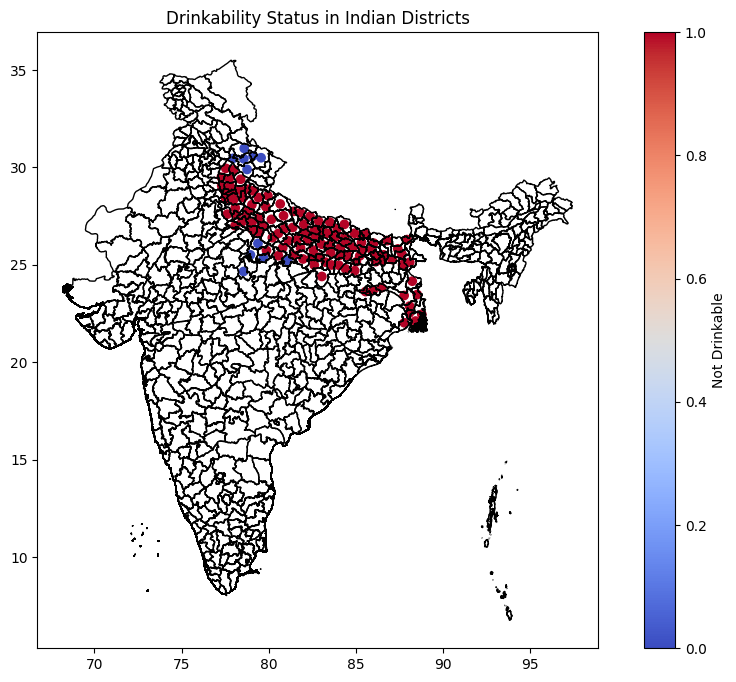

In [570]:
 # Create a GeoDataFrame from the 'ganga_districts_updated' DataFrame
gdf_districts = gpd.GeoDataFrame(
    ganga_districts_updated, 
    geometry=gpd.points_from_xy(ganga_districts_updated.longitude, ganga_districts_updated.latitude)
)

# Plot the districts on a map of India
fig, ax = plt.subplots(figsize=(12, 8))
# Load the shapefile for India districts (optional, if you want to add India's map boundaries)
india_shapefile_path = '/Users/arjunarora/Desktop/River pollution/Data/Pollution/gadm41_IND_shp/gadm41_IND_2.shp'  # Replace with the actual path
india_gdf = gpd.read_file(india_shapefile_path)
india_gdf.boundary.plot(ax=ax, color='black', linewidth=1)  # Optional, to plot India's map boundaries
gdf_districts.plot(column='not_drinkable', cmap='coolwarm', legend=True, ax=ax,
                   legend_kwds={'label': "Not Drinkable"})
ax.set_title('Drinkability Status in Indian Districts')
plt.show()

In [454]:
ganga_districts_updated['not_drinkable']

0      1
1      1
2      1
3      1
4      1
      ..
118    1
119    0
120    1
121    1
122    1
Name: not_drinkable, Length: 122, dtype: int64

Merge 2021 nightlight data to the ganga_districts_updated dataframe
Steps:
1. Get the SHRUG dataset at a district level
2. Select relevant columns
3. Fuzzy merge on district columns

In [571]:
path = '/Users/arjunarora/Desktop/River pollution/Data/Nightlight/shrug-viirs-annual-dta/'

In [572]:
nightlight_dist_df = pd.read_stata(path + "viirs_annual_pc11dist.dta")

In [573]:
nightlight_dist_df.head()

,pc11_district_id,pc11_state_id,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,year
0,532,28,0.000000,43.310623,0.464225,37733.101562,81282,2021
1,533,28,0.000000,36.743607,0.826794,32968.429688,39875,2021
2,534,28,0.000000,57.049034,1.051981,62732.773438,59633,2021
3,535,28,0.000000,44.807312,1.437214,70072.828125,48756,2021
4,536,28,11.342199,111.429657,40.741089,52148.593750,1280,2021


In [574]:
nightlight_dist_df.shape

(12800, 8)

In [575]:
nightlight_2021_df = nightlight_dist_df.loc[nightlight_dist_df['year'] == 2021]

In [576]:
nightlight_2021_df.shape

(1280, 8)

In [577]:
nightlight_2021_df['pc11_district_id'].nunique()

640

In [578]:
nightlight_2021_df.loc[nightlight_2021_df['pc11_district_id'] == '532']

,pc11_district_id,pc11_state_id,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,year
0,532,28,0.0,43.310623,0.464225,37733.101562,81282,2021
10240,532,28,0.0,39.089138,0.444262,36110.472656,81282,2021


In [579]:
nightlight_2021_grouped_df = nightlight_2021_df.groupby(by=['pc11_district_id','pc11_state_id', 'year']).mean().reset_index()

In [580]:
nightlight_2021_grouped_df

,pc11_district_id,pc11_state_id,year,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells
0,001,01,2021,0.000000,6.655489,0.183008,2840.104370,15519.0
1,002,01,2021,0.000000,20.654213,1.079616,7228.032227,6695.0
2,003,01,2021,0.000000,24.023756,0.009344,4218.039551,451404.0
3,004,01,2021,0.000000,18.076091,0.019643,1885.647095,95998.0
4,005,01,2021,0.000000,10.748653,0.610502,8106.245850,13278.0
...,...,...,...,...,...,...,...,...
635,636,34,2021,1.273081,3.881653,1.965097,147.382248,75.0
636,637,34,2021,0.000000,26.539566,2.797972,2523.770508,902.0
637,638,35,2021,0.000000,5.712275,0.027094,240.866631,8890.0
638,639,35,2021,0.000000,6.314766,0.033893,612.979828,18086.0


In [581]:
nightlight_2021_grouped_df.loc[nightlight_2021_grouped_df['pc11_district_id'] == '532']

,pc11_district_id,pc11_state_id,year,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells
531,532,28,2021,0.0,41.199881,0.454243,36921.787109,81282.0


In [582]:
#Add population census data to this table from 2011.
shrug_pc11_district = pd.read_stata("/Users/arjunarora/Desktop/River pollution/Data/SHRUG/Population census/shrug-pca11-dta/pc11_pca_clean_pc11dist.dta")
pop_cols = ['pc11_state_id', 'pc11_district_id','pc11_pca_tot_p', 'pc11_pca_no_hh']
shrug_pc11_district = shrug_pc11_district[pop_cols]
shrug_pc11_district.head()


,pc11_state_id,pc11_district_id,pc11_pca_tot_p,pc11_pca_no_hh
0,01,001,870354,113929
1,01,002,753745,103363
2,01,003,133487,21909
3,01,004,140802,18338
4,01,005,476835,90261


In [583]:
nightlight_dist_population_2021_df = nightlight_2021_grouped_df.merge(shrug_pc11_district, on=['pc11_state_id', 'pc11_district_id'])

In [584]:
nightlight_dist_population_2021_df.head(), nightlight_dist_population_2021_df.shape

(  pc11_district_id pc11_state_id  year  viirs_annual_min  viirs_annual_max  \
 0              001            01  2021               0.0          6.655489   
 1              002            01  2021               0.0         20.654213   
 2              003            01  2021               0.0         24.023756   
 3              004            01  2021               0.0         18.076091   
 4              005            01  2021               0.0         10.748653   
 
    viirs_annual_mean  viirs_annual_sum  viirs_annual_num_cells  \
 0           0.183008       2840.104370                 15519.0   
 1           1.079616       7228.032227                  6695.0   
 2           0.009344       4218.039551                451404.0   
 3           0.019643       1885.647095                 95998.0   
 4           0.610502       8106.245850                 13278.0   
 
    pc11_pca_tot_p  pc11_pca_no_hh  
 0          870354          113929  
 1          753745          103363  
 2       

In [474]:
#Add shrid2 to this dataframe, and then add district names from SHRID location keys

In [585]:
pop_census_keys = pd.read_stata("/Users/arjunarora/Desktop/River pollution/Data/SHRUG/Population census/shrug-pc-keys-dta/shrid_pc11dist_key.dta")
nightlight_dist_population_shrid_df = nightlight_dist_population_2021_df.merge(pop_census_keys, on=['pc11_state_id', 'pc11_district_id'], how='left')
nightlight_dist_population_shrid_df

,pc11_district_id,pc11_state_id,year,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh,shrid2
0,001,01,2021,0.0,6.655489,0.183008,2840.104370,15519.0,870354,113929,11-01-001-00001-000002
1,001,01,2021,0.0,6.655489,0.183008,2840.104370,15519.0,870354,113929,11-01-001-00001-000005
2,001,01,2021,0.0,6.655489,0.183008,2840.104370,15519.0,870354,113929,11-01-001-00001-000006
3,001,01,2021,0.0,6.655489,0.183008,2840.104370,15519.0,870354,113929,11-01-001-00001-000007
4,001,01,2021,0.0,6.655489,0.183008,2840.104370,15519.0,870354,113929,11-01-001-00001-000008
...,...,...,...,...,...,...,...,...,...,...,...
576674,640,35,2021,0.0,26.656397,0.201503,2592.945068,12868.0,238142,59064,11-35-640-05924-645566
576675,640,35,2021,0.0,26.656397,0.201503,2592.945068,12868.0,238142,59064,11-35-640-05924-645567
576676,640,35,2021,0.0,26.656397,0.201503,2592.945068,12868.0,238142,59064,11-35-640-05924-645568
576677,640,35,2021,0.0,26.656397,0.201503,2592.945068,12868.0,238142,59064,11-35-640-05924-645569


In [586]:
shrid_loc_names = pd.read_stata("/Users/arjunarora/Desktop/River pollution/Data/SHRUG/Population census/shrug-shrid-keys-dta/shrid_loc_names.dta")

shrid_loc_names

,shrid2,state_name,district_name,subdistrict_name,town_name,village_name,place_name
0,11-01-001-00001-000002,jammu kashmir,kupwara,kupwara,,keran,keran
1,11-01-001-00001-000005,jammu kashmir,kupwara,kupwara,,mindiyan,mindiyan
2,11-01-001-00001-000006,jammu kashmir,kupwara,kupwara,,patrin,patrin
3,11-01-001-00001-000007,jammu kashmir,kupwara,kupwara,,juma gund,juma gund
4,11-01-001-00001-000008,jammu kashmir,kupwara,kupwara,,khantha wali shalun bhatta,khantha wali shalun bhatta
...,...,...,...,...,...,...,...
576577,11-35-640-05924-645566,andaman nicobar islands,south andaman,little andaman,,butler bay forest camp-4 iii fdca,butler bay forest camp-4 iii fdca
576578,11-35-640-05924-645567,andaman nicobar islands,south andaman,little andaman,,butler bay forest camp-4 iv fdca,butler bay forest camp-4 iv fdca
576579,11-35-640-05924-645568,andaman nicobar islands,south andaman,little andaman,,red oil palm nursery camp,red oil palm nursery camp
576580,11-35-640-05924-645569,andaman nicobar islands,south andaman,little andaman,,butler bay forest camp-4 ii fdca,butler bay forest camp-4 ii fdca


In [587]:
shrid_loc_names = shrid_loc_names[['shrid2', 'state_name', 'district_name']]

In [588]:
nightlight_dist_population_shrid_name_df = nightlight_dist_population_shrid_df.merge(shrid_loc_names, how='left', on='shrid2')

In [589]:
nightlight_dist_population_shrid_name_df

,pc11_district_id,pc11_state_id,year,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh,shrid2,state_name,district_name
0,001,01,2021,0.0,6.655489,0.183008,2840.104370,15519.0,870354,113929,11-01-001-00001-000002,jammu kashmir,kupwara
1,001,01,2021,0.0,6.655489,0.183008,2840.104370,15519.0,870354,113929,11-01-001-00001-000005,jammu kashmir,kupwara
2,001,01,2021,0.0,6.655489,0.183008,2840.104370,15519.0,870354,113929,11-01-001-00001-000006,jammu kashmir,kupwara
3,001,01,2021,0.0,6.655489,0.183008,2840.104370,15519.0,870354,113929,11-01-001-00001-000007,jammu kashmir,kupwara
4,001,01,2021,0.0,6.655489,0.183008,2840.104370,15519.0,870354,113929,11-01-001-00001-000008,jammu kashmir,kupwara
...,...,...,...,...,...,...,...,...,...,...,...,...,...
576674,640,35,2021,0.0,26.656397,0.201503,2592.945068,12868.0,238142,59064,11-35-640-05924-645566,andaman nicobar islands,south andaman
576675,640,35,2021,0.0,26.656397,0.201503,2592.945068,12868.0,238142,59064,11-35-640-05924-645567,andaman nicobar islands,south andaman
576676,640,35,2021,0.0,26.656397,0.201503,2592.945068,12868.0,238142,59064,11-35-640-05924-645568,andaman nicobar islands,south andaman
576677,640,35,2021,0.0,26.656397,0.201503,2592.945068,12868.0,238142,59064,11-35-640-05924-645569,andaman nicobar islands,south andaman


In [590]:
nightlight_dist_population_shrid_name_df.loc[nightlight_dist_population_shrid_name_df['pc11_district_id'] == '532']

,pc11_district_id,pc11_state_id,year,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh,shrid2,state_name,district_name
505459,532,28,2021,0.0,41.199881,0.454243,36921.787109,81282.0,2741239,649849,11-28-532-04305-568945,andhra pradesh,adilabad
505460,532,28,2021,0.0,41.199881,0.454243,36921.787109,81282.0,2741239,649849,11-28-532-04305-568946,andhra pradesh,adilabad
505461,532,28,2021,0.0,41.199881,0.454243,36921.787109,81282.0,2741239,649849,11-28-532-04305-568947,andhra pradesh,adilabad
505462,532,28,2021,0.0,41.199881,0.454243,36921.787109,81282.0,2741239,649849,11-28-532-04305-568948,andhra pradesh,adilabad
505463,532,28,2021,0.0,41.199881,0.454243,36921.787109,81282.0,2741239,649849,11-28-532-04305-568949,andhra pradesh,adilabad
...,...,...,...,...,...,...,...,...,...,...,...,...,...
507017,532,28,2021,0.0,41.199881,0.454243,36921.787109,81282.0,2741239,649849,11-28-532-04356-570681,andhra pradesh,adilabad
507018,532,28,2021,0.0,41.199881,0.454243,36921.787109,81282.0,2741239,649849,11-28-532-04356-570682,andhra pradesh,adilabad
507019,532,28,2021,0.0,41.199881,0.454243,36921.787109,81282.0,2741239,649849,11-28-532-04356-570683,andhra pradesh,adilabad
507020,532,28,2021,0.0,41.199881,0.454243,36921.787109,81282.0,2741239,649849,11-28-532-04356-570684,andhra pradesh,adilabad


In [591]:
nightlight_dist_population_shrid_name_groupby_df = nightlight_dist_population_shrid_name_df.groupby(by=['pc11_district_id','pc11_state_id','year','state_name','district_name']).mean().reset_index()

/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_53866/3600727227.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nightlight_dist_population_shrid_name_groupby_df = nightlight_dist_population_shrid_name_df.groupby(by=['pc11_district_id','pc11_state_id','year','state_name','district_name']).mean().reset_index()


In [592]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['pc11_district_id'] == '532']

,pc11_district_id,pc11_state_id,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
575,532,28,2021,andhra pradesh,adilabad,0.0,41.199881,0.454243,36921.787109,81282.0,2741239.0,649849.0


In [593]:
ganga_districts_updated.head()

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,1_Closest_Station,1_Distance,...,STATE NAME,STATION CODE,TEMPERATURE MAX (°C),TEMPERATURE MIN (°C),TOTAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),YEAR,pH Max,pH Min,not_drinkable
0,Agra,Agra,Uttar Pradesh,Agra,27.007505,78.062924,"MULTIPOLYGON (((78.76215 26.76683, 78.75448 26...",POINT (78.06292448694016 27.00750514448138),1126,19.888379,...,UTTAR PRADESH,1126.0,33,26,490000.0,11000,2021.0,8.7,7.2,1
1,Aligarh,Aligarh,Uttar Pradesh,Aligarh,27.926166,78.077182,"MULTIPOLYGON (((78.02922 27.77695, 78.02602 27...",POINT (78.0771821412473 27.926165556871766),1145,42.831563,...,UTTAR PRADESH,1145.0,33,16,2700.0,900,2021.0,7.6,7.0,1
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),2469,12.458084,...,UTTAR PRADESH,10158.0,30.3,18.5,2100.0,1100,2021.0,8.3,7.7,1
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852),10096,54.576245,...,UTTAR\nPRADESH,10091.0,-,-,240000.0,170000,2021.0,7.6,7.6,1
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971),2499,38.559150,...,UTTAR\nPRADESH,10088.0,-,-,16000.0,7900,2021.0,7.9,7.8,1


Duplicate nightlight districts in Merged df

In [605]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['district_name'] == 'tehri garhwal']

,pc11_district_id,pc11_state_id,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
62,059,05,2021,uttarakhand,tehri garhwal,0.0,30.748981,0.342800,7549.136230,22022.0,618931.0,132714.0
65,061,05,2021,uttarakhand,tehri garhwal,0.0,30.748981,0.190803,5643.562744,29578.0,687271.0,161778.0


In [606]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['district_name'] == 'aurangabad']

,pc11_district_id,pc11_state_id,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
252,235,10,2021,bihar,aurangabad,0.0,46.516541,1.273884,22321.000000,17522.0,2540073.0,391898.0
558,515,27,2021,maharashtra,aurangabad,0.0,39.582960,0.834284,43124.998047,51691.0,3701282.0,751915.0


In [608]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['district_name'] == 'bhagalpur']

,pc11_district_id,pc11_state_id,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
239,224,10,2021,bihar,bhagalpur,0.0,37.350101,1.568282,21422.731445,13660.0,3037766.0,564711.0
248,233,10,2021,bihar,bhagalpur,0.0,35.279583,0.740874,13119.395508,17708.0,1626384.0,250884.0


In [609]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['district_name'] == 'hamirpur']

,pc11_district_id,pc11_state_id,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
29,028,02,2021,himachal pradesh,hamirpur,0.0,7.765045,0.207836,1321.213196,6357.0,454768.0,105519.0
182,168,09,2021,uttar pradesh,hamirpur,0.0,20.975875,0.519586,10942.999512,21061.0,1104285.0,204863.0


In [612]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['district_name'] == 'muzaffarpur']

,pc11_district_id,pc11_state_id,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
230,216,10,2021,bihar,muzaffarpur,0.0,43.359743,1.749803,29778.155273,17018.0,4801062.0,945703.0
235,221,10,2021,bihar,muzaffarpur,0.0,28.310515,1.350765,19813.028320,14668.0,4261566.0,835493.0


In [613]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['district_name'] == 'pratapgarh']

,pc11_district_id,pc11_state_id,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
138,126,08,2021,rajasthan,pratapgarh,0.0,57.725077,0.739141,30910.893555,41820.0,1544338.0,329119.0
145,131,08,2021,rajasthan,pratapgarh,0.0,18.060492,0.300831,7065.317627,23486.0,867848.0,178726.0
187,173,09,2021,uttar pradesh,pratapgarh,0.0,31.546465,1.092257,21744.661133,19908.0,3209141.0,533546.0


In [615]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['district_name'] == 'samastipur']

,pc11_district_id,pc11_state_id,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
236,221,10,2021,bihar,samastipur,0.0,28.310515,1.350765,19813.028320,14668.0,4261566.0,835493.0
250,233,10,2021,bihar,samastipur,0.0,35.279583,0.740874,13119.395508,17708.0,1626384.0,250884.0


In [616]:
130-8#8 duplicates from above

122

Missing nightlight districts from merged df

In [621]:
nightlight_dist_population_shrid_name_groupby_df.to_csv("nightlight_dist_population_shrid_name_groupby_df.csv")

In [611]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['district_name'] == 'kanshiram nagar']

,pc11_district_id,pc11_state_id,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
216,202,09,2021,uttar pradesh,kanshiram nagar,0.0,17.526577,0.784023,8512.140137,10857.0,1436719.0,237903.0


In [620]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['district_name'] == 'amethi']

,pc11_district_id,pc11_state_id,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh


In [ ]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['district_name'] == 'kanshiram nagar']

In [ ]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['district_name'] == 'kanshiram nagar']

In [607]:
nightlight_dist_population_shrid_name_groupby_df.loc[nightlight_dist_population_shrid_name_groupby_df['district_name'] == 'agra']

,pc11_district_id,pc11_state_id,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
160,146,09,2021,uttar pradesh,agra,0.0,50.600904,2.133486,47659.945312,22339.0,4418797.0,710566.0


In [664]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Perform fuzzy matching on district names
def fuzzy_matching(district_name, choices):
    match = process.extractOne(district_name, choices)
    if match[1] >= 90:  # Set a threshold for similarity score
        return match[0]
    else:
        return None

# Apply fuzzy matching to create a new column with matching district names
ganga_districts_updated['nightlight_district_matched'] = ganga_districts_updated['matched_district_name'].apply(
    lambda x: fuzzy_matching(str(x), nightlight_dist_population_shrid_name_groupby_df['district_name'].unique())
)



In [665]:
merged_df = ganga_districts_updated.merge(nightlight_dist_population_shrid_name_groupby_df, 
                                    left_on=['nightlight_district_matched'], 
                                    right_on=['district_name'], 
                                    how='left')



In [647]:
merged_df

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,1_Closest_Station,1_Distance,...,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
0,Agra,Agra,Uttar Pradesh,Agra,27.007505,78.062924,"MULTIPOLYGON (((78.76215 26.76683, 78.75448 26...",POINT (78.06292448694016 27.00750514448138),1126,19.888379,...,2021.0,uttar pradesh,agra,0.0,50.600904,2.133486,47659.945312,22339.0,4418797.0,710566.0
1,Aligarh,Aligarh,Uttar Pradesh,Aligarh,27.926166,78.077182,"MULTIPOLYGON (((78.02922 27.77695, 78.02602 27...",POINT (78.0771821412473 27.926165556871766),1145,42.831563,...,2021.0,uttar pradesh,aligarh,0.0,34.529350,1.496871,30495.748047,20373.0,3673889.0,611371.0
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,"MULTIPOLYGON (((82.08973 24.81590, 82.08187 24...",POINT (81.9648086868582 25.299888574473403),2469,12.458084,...,2021.0,uttar pradesh,allahabad,0.0,63.684042,2.144662,63042.345703,29395.0,5954391.0,976733.0
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,"MULTIPOLYGON (((82.87720 26.33041, 82.87294 26...",POINT (82.65982592111567 26.423722608608852),10096,54.576245,...,2021.0,uttar pradesh,ambedkar nagar,0.0,37.028748,1.105799,14338.898926,12967.0,2397888.0,368728.0
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971),2499,38.559150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,Unnao,Unnao,Uttar Pradesh,Unnao,26.614340,80.549960,"MULTIPOLYGON (((80.65694 26.13872, 80.65340 26...",POINT (80.54996016514015 26.6143397673387),1740,10.138698,...,2021.0,uttar pradesh,unnao,0.0,34.368299,0.816590,20082.409180,24593.0,3108367.0,588533.0
126,Uttarkashi,Uttarkashi,Uttarakhand,Uttarkashi,30.978351,78.589517,"MULTIPOLYGON (((78.58400 30.67935, 78.58540 30...",POINT (78.58951654754148 30.9783506463683),1491,10.112891,...,2021.0,uttarakhand,uttarkashi,0.0,11.708162,0.049297,2201.292480,44654.0,330086.0,67602.0
127,Vaishali,Vaishali,Bihar,Vaishali,25.763019,85.362025,"MULTIPOLYGON (((85.41669 25.94031, 85.42208 25...",POINT (85.3620254879767 25.763019030177777),2600,8.802316,...,2021.0,bihar,vaishali,0.0,66.027626,1.934365,20749.931641,10727.0,3495021.0,626087.0
128,Varanasi,Varanasi,Uttar Pradesh,Varanasi,25.390631,82.909030,"MULTIPOLYGON (((83.17112 25.51279, 83.16818 25...",POINT (82.90902975267382 25.39063107192604),2482,5.692258,...,2021.0,uttar pradesh,varanasi,0.0,50.961670,3.778441,31145.688477,8243.0,3676841.0,560162.0


In [603]:
merged_df.loc[merged_df['district_name'].isna()]

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,1_Closest_Station,1_Distance,...,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971),2499,38.559150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,Hathras,Hathras,Uttar Pradesh,Hathras,27.576148,78.144032,"MULTIPOLYGON (((77.95309 27.29800, 77.95284 27...",POINT (78.1440318563892 27.57614775999232),1123,43.004612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,Jyotiba Phule Nagar (Amroha),Amroha,Uttar Pradesh,Amroha,28.843397,78.349147,"MULTIPOLYGON (((78.38847 28.76976, 78.39906 28...",POINT (78.34914672256072 28.84339731400822),1751,10.714022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,Kanshiram Nagar (Kasganj),Kasganj,Uttar Pradesh,Kasganj,27.782238,78.836772,"MULTIPOLYGON (((78.91306 27.88150, 78.91354 27...",POINT (78.83677186845212 27.782238146788355),2490,16.390963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,NORTH 24-PARGANAS,North 24 Parganas,West Bengal,North 24 Parganas,22.463699,88.778291,"MULTIPOLYGON (((88.89389 21.64917, 88.89333 21...",POINT (88.77829065745648 22.463698868903336),2550,4.905029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,SOUTH 24-PARGANAS,South 24 Parganas,West Bengal,South 24 Parganas,22.114312,88.416060,"MULTIPOLYGON (((88.02139 21.57111, 88.02111 21...",POINT (88.41605968549797 22.114311645101488),1469,24.170753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,Sambhal,Sambhal,Uttar Pradesh,Sambhal,28.454091,78.527646,"MULTIPOLYGON (((78.57306 28.08656, 78.56677 28...",POINT (78.52764640090821 28.454090988177022),2488,27.108190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,Sant Ravidas Nagar (Bhadohi),Sant Ravi Das Nagar,Uttar Pradesh,Sant Ravi Das Nagar,25.350985,82.455649,"MULTIPOLYGON (((82.21389 25.27858, 82.21722 25...",POINT (82.45564937253809 25.350984829162797),10152,2.519553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,Shamli,Shamli,Uttar Pradesh,Shamli,29.499573,77.276470,"MULTIPOLYGON (((77.15421 29.31692, 77.15360 29...",POINT (77.27646954647709 29.4995729640373),30032,17.464694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,Shravasti,Shravasti,Uttar Pradesh,Shravasti,27.678408,81.815827,"MULTIPOLYGON (((81.71346 27.33213, 81.71272 27...",POINT (81.81582704181758 27.678408481716605),1354,106.044381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [604]:
merged_df.to_csv("merged_df.csv")

In [624]:
merged_df = pd.read_csv("/Users/arjunarora/Desktop/River pollution/Data/Pollution/merged_df.csv")

In [648]:
merged_df.loc[merged_df['district_name'].isna()]

,District,matched_district_name,NAME_1,NAME_2,latitude,longitude,geometry,district_centroid,1_Closest_Station,1_Distance,...,year,state_name,district_name,viirs_annual_min,viirs_annual_max,viirs_annual_mean,viirs_annual_sum,viirs_annual_num_cells,pc11_pca_tot_p,pc11_pca_no_hh
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,"MULTIPOLYGON (((81.60742 26.17690, 81.60516 26...",POINT (81.63081442129227 26.28678399710971),2499,38.559150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,Hathras,Hathras,Uttar Pradesh,Hathras,27.576148,78.144032,"MULTIPOLYGON (((77.95309 27.29800, 77.95284 27...",POINT (78.1440318563892 27.57614775999232),1123,43.004612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,Jyotiba Phule Nagar (Amroha),Amroha,Uttar Pradesh,Amroha,28.843397,78.349147,"MULTIPOLYGON (((78.38847 28.76976, 78.39906 28...",POINT (78.34914672256072 28.84339731400822),1751,10.714022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,Kanshiram Nagar (Kasganj),Kasganj,Uttar Pradesh,Kasganj,27.782238,78.836772,"MULTIPOLYGON (((78.91306 27.88150, 78.91354 27...",POINT (78.83677186845212 27.782238146788355),2490,16.390963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,NORTH 24-PARGANAS,North 24 Parganas,West Bengal,North 24 Parganas,22.463699,88.778291,"MULTIPOLYGON (((88.89389 21.64917, 88.89333 21...",POINT (88.77829065745648 22.463698868903336),2550,4.905029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,SOUTH 24-PARGANAS,South 24 Parganas,West Bengal,South 24 Parganas,22.114312,88.416060,"MULTIPOLYGON (((88.02139 21.57111, 88.02111 21...",POINT (88.41605968549797 22.114311645101488),1469,24.170753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,Sambhal,Sambhal,Uttar Pradesh,Sambhal,28.454091,78.527646,"MULTIPOLYGON (((78.57306 28.08656, 78.56677 28...",POINT (78.52764640090821 28.454090988177022),2488,27.108190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,Sant Ravidas Nagar (Bhadohi),Sant Ravi Das Nagar,Uttar Pradesh,Sant Ravi Das Nagar,25.350985,82.455649,"MULTIPOLYGON (((82.21389 25.27858, 82.21722 25...",POINT (82.45564937253809 25.350984829162797),10152,2.519553,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,Shamli,Shamli,Uttar Pradesh,Shamli,29.499573,77.276470,"MULTIPOLYGON (((77.15421 29.31692, 77.15360 29...",POINT (77.27646954647709 29.4995729640373),30032,17.464694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,Shravasti,Shravasti,Uttar Pradesh,Shravasti,27.678408,81.815827,"MULTIPOLYGON (((81.71346 27.33213, 81.71272 27...",POINT (81.81582704181758 27.678408481716605),1354,106.044381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [666]:
merged_df.columns

Index(['District', 'matched_district_name', 'NAME_1', 'NAME_2', 'latitude',
       'longitude', 'geometry', 'district_centroid', '1_Closest_Station',
       '1_Distance', '2_Closest_Station', '2_Distance', '3_Closest_Station',
       '3_Distance', '4_Closest_Station', '4_Distance', '5_Closest_Station',
       '5_Distance', 'BIO- CHEMICAL OXYGEN DEMAND Max (mg/L)',
       'BIO- CHEMICAL OXYGEN DEMAND Min\n(mg/L)',
       'CONDUCTIVITY Max (µmhos/cm)', 'CONDUCTIVITY Min\n(µmhos/cm)',
       'DISSOLVED OXYGEN MAX (mg/L)', 'DISSOLVED OXYGEN MIN\n(mg/L)',
       'FECAL COLIFORM MAX (MPN/100ML)', 'FECAL COLIFORM MIN (MPN/100ML)',
       'FECAL STREPTOCOCCI MAX (MPN/100ML)',
       'FECAL STREPTOCOCCI MIN (MPN/100ML)', 'NAME OF MONITORING LOCATION',
       'NITRATE MAX (mg/L)', 'NITRATE MIN\n(mg/L)', 'STATE NAME',
       'STATION CODE', 'TEMPERATURE MAX (°C)', 'TEMPERATURE MIN (°C)',
       'TOTAL COLIFORM MAX (MPN/100ML)', 'TOTAL COLIFORM MIN (MPN/100ML)',
       'YEAR', 'pH Max', 'pH Min', 

In [654]:
merged_gdf_plot = gdf.merge(merged_df, on = 'NAME_2')


In [656]:
merged_gdf_plot.head()

,District_x,matched_district_name_x,NAME_1_x,NAME_2,latitude_x,longitude_x,geometry_x,district_centroid_x,1_Closest_Station_x,1_Distance_x,...,year_y,state_name_y,district_name_y,viirs_annual_min_y,viirs_annual_max_y,viirs_annual_mean_y,viirs_annual_sum_y,viirs_annual_num_cells_y,pc11_pca_tot_p_y,pc11_pca_no_hh_y
0,Agra,Agra,Uttar Pradesh,Agra,27.007505,78.062924,POINT (78.06292 27.00751),POINT (78.06292448694016 27.00750514448138),1126,19.888379,...,2021.0,uttar pradesh,agra,0.0,50.600904,2.133486,47659.945312,22339.0,4418797.0,710566.0
1,Aligarh,Aligarh,Uttar Pradesh,Aligarh,27.926166,78.077182,POINT (78.07718 27.92617),POINT (78.0771821412473 27.926165556871766),1145,42.831563,...,2021.0,uttar pradesh,aligarh,0.0,34.529350,1.496871,30495.748047,20373.0,3673889.0,611371.0
2,Allahabad,Allahabad,Uttar Pradesh,Allahabad,25.299889,81.964809,POINT (81.96481 25.29989),POINT (81.9648086868582 25.299888574473403),2469,12.458084,...,2021.0,uttar pradesh,allahabad,0.0,63.684042,2.144662,63042.345703,29395.0,5954391.0,976733.0
3,Ambedkarnagar,Ambedkar Nagar,Uttar Pradesh,Ambedkar Nagar,26.423723,82.659826,POINT (82.65983 26.42372),POINT (82.65982592111567 26.423722608608852),10096,54.576245,...,2021.0,uttar pradesh,ambedkar nagar,0.0,37.028748,1.105799,14338.898926,12967.0,2397888.0,368728.0
4,Amethi,Amethi,Uttar Pradesh,Amethi,26.286784,81.630814,POINT (81.63081 26.28678),POINT (81.63081442129227 26.28678399710971),2499,38.559150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


AttributeError: 'Series' object has no attribute 'centroid'

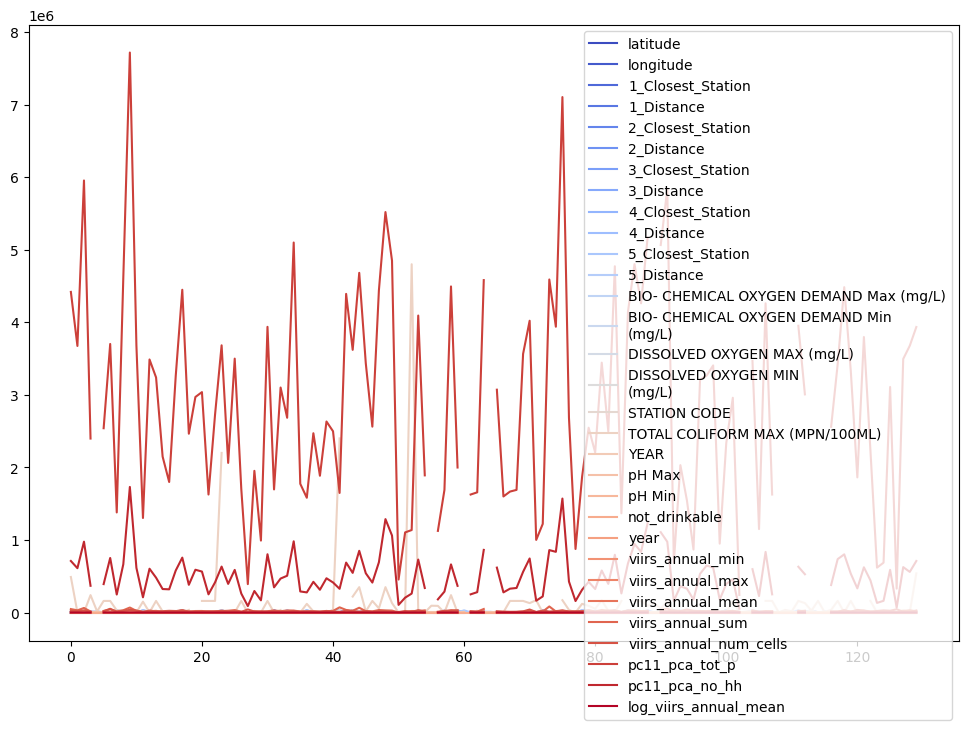

In [669]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Set the color map to use a logarithmic scale
cmap = plt.get_cmap('coolwarm')
vmin = merged_df['viirs_annual_mean'].min()
vmax = merged_df['viirs_annual_mean'].max()

# Normalize the values
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the GeoDataFrame
merged_df.plot(column='viirs_annual_mean', cmap=cmap, legend=True, ax=ax)

# Add annotations for district names at the centroids of the districts
for x, y, label in zip(merged_df.geometry.centroid.x, merged_df.geometry.centroid.y, merged_df['matched_district_name']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center')

# Set colorbar and title
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Avoids error when calling colorbar without mappable
cbar = plt.colorbar(sm)
cbar.set_label('viirs_annual_mean')

ax.set_title('Average viirs_annual_mean in Indian Districts')
plt.show()


/var/folders/wm/jf5bq5r94mqgp8j4gnpmb7xw0000gn/T/ipykernel_53866/172176838.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


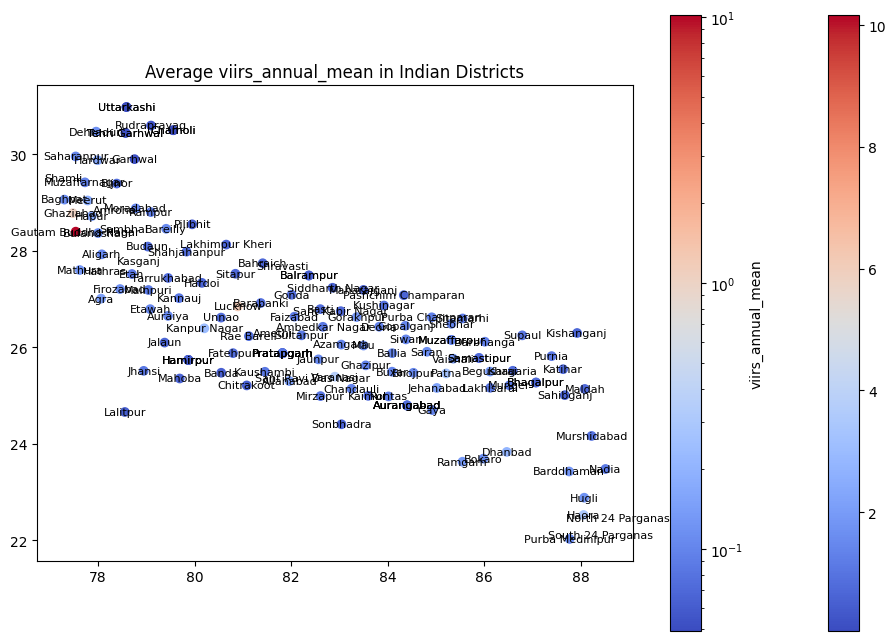

In [661]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Set the color map to use a logarithmic scale
cmap = plt.get_cmap('coolwarm')
vmin = merged_df['viirs_annual_mean'].min()
vmax = merged_df['viirs_annual_mean'].max()

# Normalize the values
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Create a GeoDataFrame using the 'geometry' column
gdf = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.longitude, merged_df.latitude))

# Plot the GeoDataFrame
gdf.plot(column='viirs_annual_mean', cmap=cmap, legend=True, ax=ax)

# Add annotations for district names at the centroids of the districts
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['matched_district_name']):
    ax.text(x, y, label, fontsize=8, ha='center', va='center')

# Set colorbar and title
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Avoids error when calling colorbar without mappable
cbar = plt.colorbar(sm)
cbar.set_label('viirs_annual_mean')

ax.set_title('Average viirs_annual_mean in Indian Districts')
plt.show()


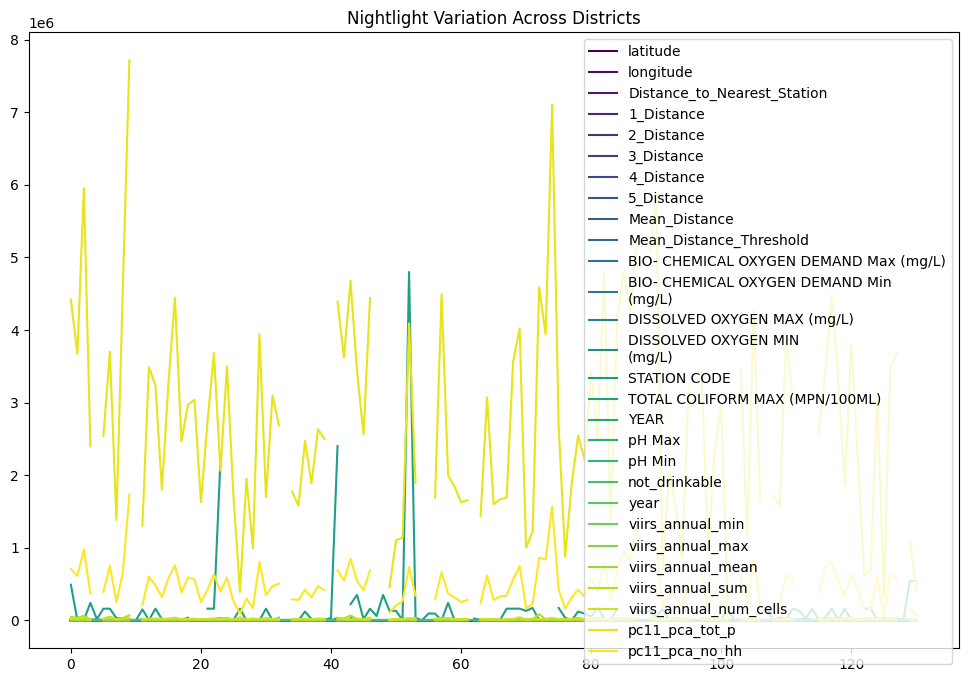

In [505]:
# Plot the nightlight variation map
fig, ax = plt.subplots(figsize=(12, 8))
merged_df.plot(column='nightlight', cmap='viridis', legend=True, ax=ax)
ax.set_title('Nightlight Variation Across Districts')
plt.show()

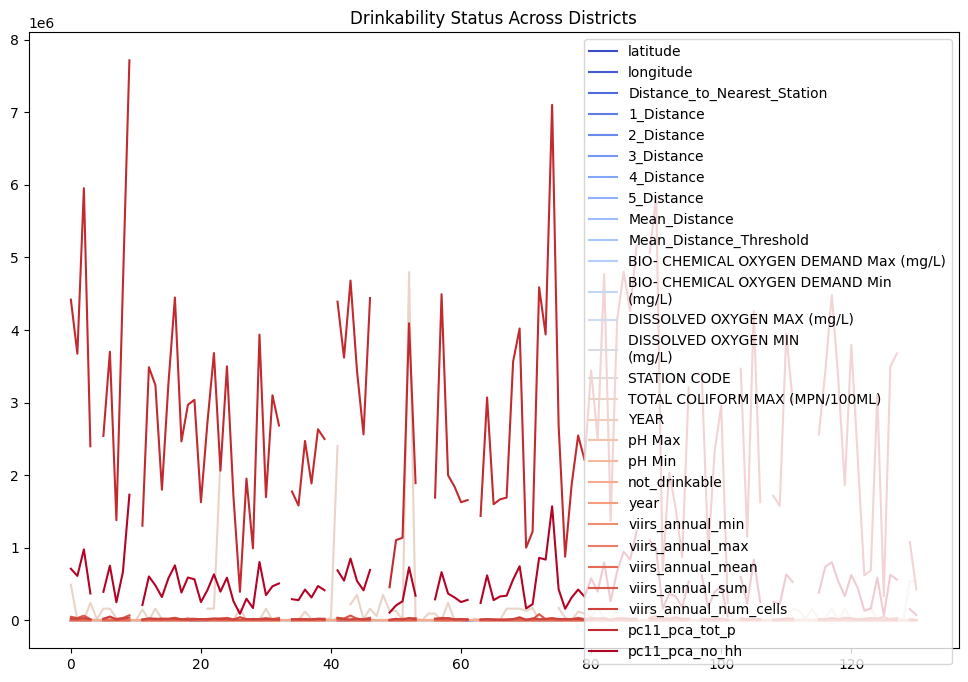

In [506]:
# Plot the drinkability status map
fig, ax = plt.subplots(figsize=(12, 8))
merged_df.plot(column='drinkability_status', cmap='coolwarm', legend=True, ax=ax)
ax.set_title('Drinkability Status Across Districts')
plt.show()

In [511]:
merged_df.plot(column='viirs_annual_mean', cmap='viridis', legend=True, ax=ax)

<AxesSubplot: title={'center': 'Drinkability Status Across Districts'}>

In [670]:
import statsmodels.api as sm

# Select the relevant columns for the analysis
data = merged_df[['TOTAL COLIFORM MAX (MPN/100ML)', 'viirs_annual_mean']]

# Drop rows with missing values
data = data.dropna()

# Define the independent variable (X) and dependent variable (y)
X = data['TOTAL COLIFORM MAX (MPN/100ML)']
y = data['viirs_annual_mean']

# Add a constant to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      viirs_annual_mean   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     14.67
Date:                Thu, 10 Aug 2023   Prob (F-statistic):           0.000218
Time:                        15:18:42   Log-Likelihood:                -171.00
No. Observations:                 108   AIC:                             346.0
Df Residuals:                     106   BIC:                             351.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [671]:
import statsmodels.api as sm

# Select the relevant columns for the analysis
data = merged_df[['not_drinkable', 'viirs_annual_mean']]

# Drop rows with missing values
data = data.dropna()

# Define the independent variable (X) and dependent variable (y)
X = data['not_drinkable']
y = data['viirs_annual_mean']

# Add a constant to the independent variable
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      viirs_annual_mean   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     7.218
Date:                Thu, 10 Aug 2023   Prob (F-statistic):            0.00826
Time:                        15:19:27   Log-Likelihood:                -189.43
No. Observations:                 120   AIC:                             382.9
Df Residuals:                     118   BIC:                             388.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5035      0.341      1.474

In [675]:
import statsmodels.api as sm

# Select the relevant columns for the analysis
data = merged_df[['not_drinkable', 'viirs_annual_mean', 'pc11_pca_tot_p']]

# Drop rows with missing values
data = data.dropna()

# Calculate viirs_annual_mean divided by pc11_pca_tot_p
data['nightlight_per_capita'] = data['viirs_annual_mean'] / data['pc11_pca_tot_p']

# Define the independent variables (X) and dependent variable (y)
X = data['not_drinkable']
y = data['nightlight_per_capita']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())


                              OLS Regression Results                             
Dep. Variable:     nightlight_per_capita   R-squared:                       0.002
Model:                               OLS   Adj. R-squared:                 -0.006
Method:                    Least Squares   F-statistic:                    0.2619
Date:                   Thu, 10 Aug 2023   Prob (F-statistic):              0.610
Time:                           15:37:08   Log-Likelihood:                 1541.3
No. Observations:                    120   AIC:                            -3079.
Df Residuals:                        118   BIC:                            -3073.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           

In this analysis, the not_drinkable variable seems to have a statistically significant positive effect on nightlight intensity, based on the coefficient estimate, the p-value, and the confidence interval. However, the low R-squared value suggests that there may be other factors not captured by the model that influence nightlight intensity. Remember that correlation does not imply causation, and further analysis may be needed to understand the underlying relationships.

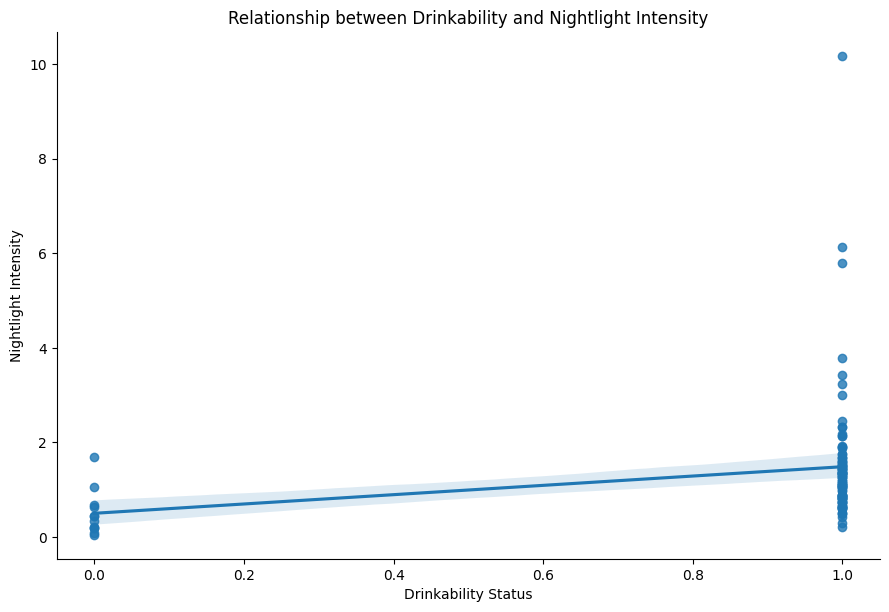

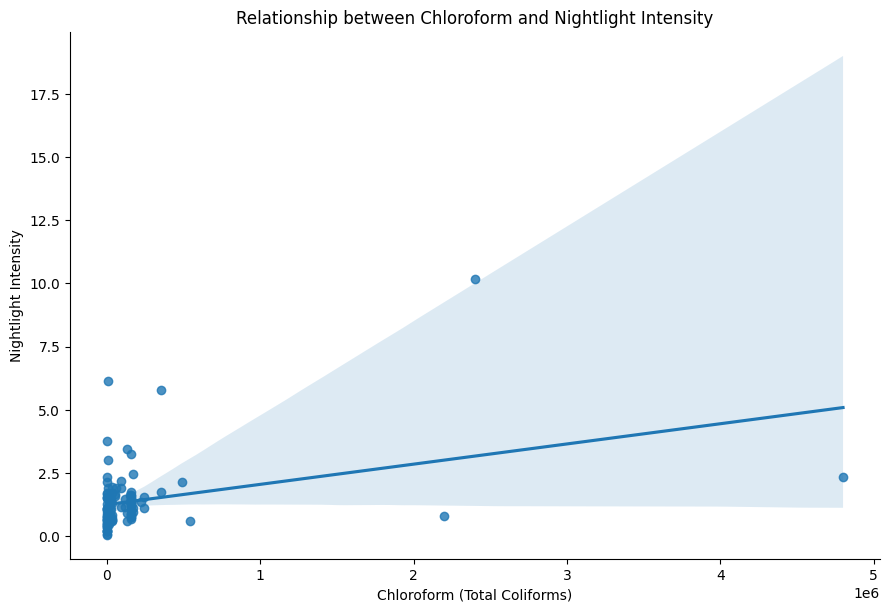

In [672]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns for the analysis
data = merged_df[['not_drinkable', 'viirs_annual_mean', 'TOTAL COLIFORM MAX (MPN/100ML)']]

# Drop rows with missing values
data = data.dropna()

# Create a scatter plot with regression line for not_drinkable vs viirs_annual_mean
sns.lmplot(x='not_drinkable', y='viirs_annual_mean', data=data, height=6, aspect=1.5)
plt.title('Relationship between Drinkability and Nightlight Intensity')
plt.xlabel('Drinkability Status')
plt.ylabel('Nightlight Intensity')
plt.show()

# Create a scatter plot with regression line for chloroform vs viirs_annual_mean
sns.lmplot(x='TOTAL COLIFORM MAX (MPN/100ML)', y='viirs_annual_mean', data=data, height=6, aspect=1.5)
plt.title('Relationship between Chloroform and Nightlight Intensity')
plt.xlabel('Chloroform (Total Coliforms)')
plt.ylabel('Nightlight Intensity')
plt.show()


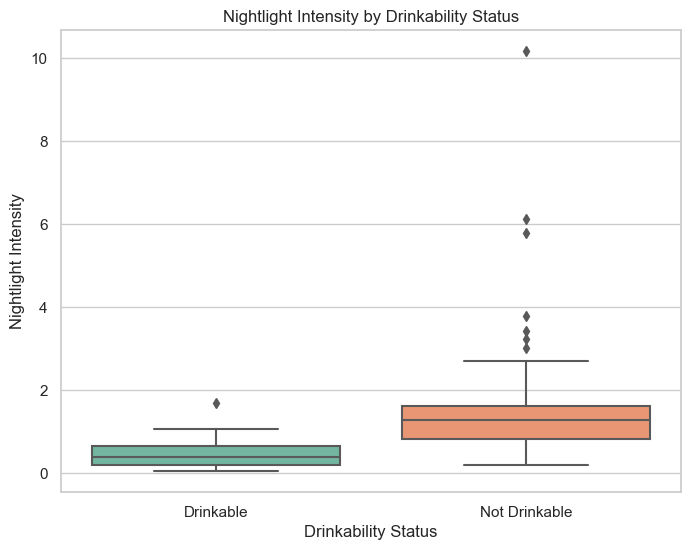

In [673]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns for the analysis
data = merged_df[['not_drinkable', 'viirs_annual_mean']]

# Drop rows with missing values
data = data.dropna()

# Set style for the plot
sns.set(style="whitegrid")

# Create a box plot to visualize nightlight intensity by drinkability status
plt.figure(figsize=(8, 6))
sns.boxplot(x='not_drinkable', y='viirs_annual_mean', data=data, palette='Set2')

# Customize the plot
plt.title('Nightlight Intensity by Drinkability Status')
plt.xlabel('Drinkability Status')
plt.ylabel('Nightlight Intensity')
plt.xticks(ticks=[0, 1], labels=['Drinkable', 'Not Drinkable'])

# Show the plot
plt.show()


Load rest of the years of pollution data. Station code wise year wise river measurements


Steps:
1. Read all the excels from all the years, combine the sheets in the excels

In [686]:
import os
import regex as re
folder_path = 'Pollution/ganga_all_station_codes/excel_use'

In [690]:
# List to store dataframes for each year
dfs_by_year = []

# Regular expression pattern to extract the year
year_pattern = r'\d{4}'

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(folder_path, filename)
        
        # Extract the year from the filename using regex
        match = re.search(year_pattern, filename)
        if match:
            year = match.group()
        else:
            year = 'Unknown'  # Use a default value if year is not found
        
        # Read all sheets from the Excel file
        sheets = pd.read_excel(file_path, sheet_name=None, header=None)
        
        # Process each sheet
        for sheet_name, sheet_data in sheets.items():
            # Find the row index where the header columns start
            header_row_index = (sheet_data == "STATION CODE").any(axis=1).idxmax()
            
            # Read the sheet again, skipping rows until the header row
            sheet_data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=header_row_index)
            
            # Add the year column
            sheet_data['Year'] = year
            
            # Append the dataframe to the list
            dfs_by_year.append(sheet_data)

# Concatenate all dataframes in the list
final_df = pd.concat(dfs_by_year, ignore_index=True)

print(final_df)

                STATION CODE  \
0                        NaN   
1     WATER QUALITY CRITERIA   
2                       1491   
3                       1484   
4                       1486   
...                      ...   
8711                    2065   
8712                    2235   
8713                    3104   
8714                    3110   
8715                    1531   

                                              LOCATIONS        STATE  \
0                                                   NaN          NaN   
1                                                   NaN                
2                 BHAGIRATHI AT GANGOTRI, UTTAR PRADESH  UTTARAKHAND   
3     ALKANANDA B/C MANDAKINI AT RUDRA PRAYAG, UTTAR...  UTTARAKHAND   
4     ALKANANDA A/C MANDAKINI AT RUDRAPRAYAG, UTTAR ...  UTTARAKHAND   
...                                                 ...          ...   
8711                                                NaN          NaN   
8712                                   

In [691]:
dfs_by_year[0]

,STATION CODE,LOCATIONS,STATE,TEMPERATURE ºC,Unnamed: 4,Unnamed: 5,D.O. (mg/l),Unnamed: 7,Unnamed: 8,pH,...,NITRATE- N+ NITRITE-N (mg/l),Unnamed: 19,Unnamed: 20,FECAL COLIFORM (MPN/100ml),Unnamed: 22,Unnamed: 23,TOTAL COLIFORM (MPN/100ml),Unnamed: 25,Unnamed: 26,Year
0,NaN,NaN,NaN,Min,Max,Mean,Min,Max,Mean,Min,...,Min,Max,Mean,Min,Max,Mean,Min,Max,Mean,2013
1,WATER QUALITY CRITERIA,NaN,,,NaN,NaN,> 4 mg/l,NaN,NaN,6.5-8.5,...,,NaN,NaN,< 2500 MPN/100ml,NaN,NaN,< 5000 MPN/100ml,NaN,NaN,2013
2,1491,"BHAGIRATHI AT GANGOTRI, UTTAR PRADESH",UTTARAKHAND,3.3,7,5.2,8.3,8.8,8.6,8.4,...,0,0,0,220,220,220,220,220,220,2013
3,1484,"ALKANANDA B/C MANDAKINI AT RUDRA PRAYAG, UTTAR...",UTTARAKHAND,11.3,19,15.4,7.4,10.6,8.7,7.4,...,0,0,0,790,790,790,1700,1700,1700,2013
4,1486,"ALKANANDA A/C MANDAKINI AT RUDRAPRAYAG, UTTAR ...",UTTARAKHAND,11.3,19,16,7.6,10,8.6,7.5,...,0,0,0,78,78,78,230,230,230,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,1053,"GANGA AT DAKSHMINESWAR, WEST BENGAL",WEST BENGAL,16,32,26.7,4,8.5,5.9,7.6,...,0.11,1.02,1,70000,1100000,425313,85000,4500000,1075588,2013
60,1471,"GANGA AT HOWRAH-SHIVPUR, WEST BENGAL",WEST BENGAL,19,30,25.9,4.4,7.4,6,7.2,...,0.3,1.55,1,1,700000,237059,110000,4500000,855882,2013
61,1470,"GANGA AT GARDEN REACH, WEST BENGAL",WEST BENGAL,20,30,25.6,4.5,8.5,6.1,7.7,...,0.09,2.56,2,1,650000,300294,165000,2500000,942941,2013
62,1052,"GANGA AT ULUBERIA, WEST BENGAL",WEST BENGAL,15,30,25.7,3.6,8.8,5.4,7.2,...,0.1,1.44,1,4000,220000,69500,11000,500000,189706,2013


In [692]:
dfs_by_year[1]

,STATION CODE,LOCATIONS,STATE,TEMPERATURE ºC,Unnamed: 4,Unnamed: 5,D.O. (mg/l),Unnamed: 7,Unnamed: 8,pH,...,NITRATE- N+ NITRITE-N (mg/l),Unnamed: 19,Unnamed: 20,FECAL COLIFORM (MPN/100ml),Unnamed: 22,Unnamed: 23,TOTAL COLIFORM (MPN/100ml),Unnamed: 25,Unnamed: 26,Year
0,NaN,NaN,NaN,Min,Max,Mean,Min,Max,Mean,Min,...,Min,Max,Mean,Min,Max,Mean,Min,Max,Mean,2013
1,WATER QUALITY CRITERIA,NaN,,,NaN,NaN,> 4 mg/l,NaN,NaN,6.5-8.5,...,,NaN,NaN,< 2500 MPN/100ml,NaN,NaN,< 5000 MPN/100ml,NaN,NaN,2013
2,1492,"YAMUNA AT YAMUNOTRI, UTTAR PRADESH",UTTARAKHAND,2.8,3,2.86,7.9,8.4,8.2,7.8,...,0,0,0,220,220,220,220,220,220,2013
3,1493,"YAMUNA AT HANUMANCHATTI, UTTAR PRADESH",UTTARAKHAND,8,13.2,10.6,7.1,8.8,8,8.2,...,0,0,0,18,18,18,33,33,33,2013
4,1494,"YAMUNA AT U/S OF LAKHWAR DAM, U.P",UTTARAKHAND,12.2,23,19.6,5.2,8.8,7.4,7.8,...,0,0,0,7000,7000,7000,9400,9400,9400,2013
5,1490,"YAMUNA AT U/S DAK PATTHAR, UTTAR PARDESH",UTTARAKHAND,12.8,23.2,19.1,6,8.4,7.3,7.8,...,0,0,0,180,35000,12293,21,35000,7512,2013
6,1553,"YAMUNA , U/S PAONTA SAHIB, H.P",HIMACHAL PRADESH,13,28,19.5,6.2,24,8.9,7,...,0.22,1.66,1.15,4,16,10,12,29,21,2013
7,1554,"YAMUNA , D/S PAONTA SAHIB, H.P",HIMACHAL PRADESH,14,29,20.4,6,27,9,6.6,...,0.26,1.05,1,3,15,10,10,28,21,2013
8,1117,YAMUNA AT HATHNIKUND HARYANA,HARYANA,,,,,,,,...,,,,,,,,,,2013
9,1496,"YAMUNA AT KALANAUR, ...",HARYANA,,,,,,,,...,,,,,,,,,,2013


In [693]:
final_df

,STATION CODE,LOCATIONS,STATE,TEMPERATURE ºC,Unnamed: 4,Unnamed: 5,D.O. (mg/l),Unnamed: 7,Unnamed: 8,pH,...,BIO- CHEMICAL OXYGEN DEMAND Min\n(mg/L),BIO- CHEMICAL OXYGEN DEMAND Max (mg/L),NITRATE MIN\n(mg/L),NITRATE MAX (mg/L),FECAL COLIFORM MIN (MPN/100ML),FECAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),TOTAL COLIFORM MAX (MPN/100ML),FECAL STREPTOCOCCI MIN (MPN/100ML),FECAL STREPTOCOCCI MAX (MPN/100ML)
0,NaN,NaN,NaN,Min,Max,Mean,Min,Max,Mean,Min,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WATER QUALITY CRITERIA,NaN,,,NaN,NaN,> 4 mg/l,NaN,NaN,6.5-8.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1491,"BHAGIRATHI AT GANGOTRI, UTTAR PRADESH",UTTARAKHAND,3.3,7,5.2,8.3,8.8,8.6,8.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1484,"ALKANANDA B/C MANDAKINI AT RUDRA PRAYAG, UTTAR...",UTTARAKHAND,11.3,19,15.4,7.4,10.6,8.7,7.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1486,"ALKANANDA A/C MANDAKINI AT RUDRAPRAYAG, UTTAR ...",UTTARAKHAND,11.3,19,16,7.6,10,8.6,7.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8711,2065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.6,2.6,0.8,1.2,300,730,1100,2000,210,210
8712,2235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.2,2.6,0.6,1,360,730,910,2000,-,-
8713,3104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-,-,-,-,-,-,-,-,-,-
8714,3110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-,-,-,-,-,-,-,-,-,-


In [728]:

def read_and_concatenate_excel_sheets(file_path):
    # Read all sheets of the Excel file into a dictionary of dataframes
    all_sheets = pd.read_excel(file_path, sheet_name=None, header=None)
    
    concatenated_dfs = []  # List to store concatenated dataframes
    
    # Iterate through each sheet
    for sheet_name, sheet_df in all_sheets.items():
        # Find the index of the row where "STATION CODE" is present
        print(file_path, sheet_name)
        header_row_index = sheet_df.index[sheet_df.apply(lambda row: 'STATION CODE' in row.values or 'station code' in row.values or 'Station Code' in row.values or 'Station code' in row.values or 'station Code' in row.values or 'Statio n Code' in row.values , axis=1)].tolist()[0]
        
        # Re-read the sheet skipping rows until the header row
        cleaned_sheet_df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=header_row_index)
        
        concatenated_dfs.append(cleaned_sheet_df)  # Append to the list
    
    # Concatenate all cleaned dataframes into a single dataframe
    concatenated_df = pd.concat(concatenated_dfs, ignore_index=True)
    
    return concatenated_df

In [729]:
file_years = []
for filename in os.listdir(folder_path):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(folder_path, filename)
        # Extract the year from the filename using regex
        match = re.search(year_pattern, filename)
        if match:
            year = match.group()
        else:
            year = 'Unknown'  # Use a default value if year is not found
        file_years.append((file_path, year))

sorted_file_years = sorted(file_years, key=lambda x: x[1])



In [730]:
sorted_file_years

[('Pollution/ganga_all_station_codes/excel_use/WQuality_river_2012.xlsx',
  '2012'),
 ('Pollution/ganga_all_station_codes/excel_use/WQuality_river_2013.xlsx',
  '2013'),
 ('Pollution/ganga_all_station_codes/excel_use/WQuality_river_2014.xlsx',
  '2014'),
 ('Pollution/ganga_all_station_codes/excel_use/NWMP_DATA_2015.xlsx', '2015'),
 ('Pollution/ganga_all_station_codes/excel_use/Water_Quality_data_of_River_2016.xlsx',
  '2016'),
 ('Pollution/ganga_all_station_codes/excel_use/Water_Quality_Rivers_2017.xlsx',
  '2017'),
 ('Pollution/ganga_all_station_codes/excel_use/WQuality_River-Data-2018.xlsx',
  '2018'),
 ('Pollution/ganga_all_station_codes/excel_use/WQuality_River-Data-2019.xlsx',
  '2019'),
 ('Pollution/ganga_all_station_codes/excel_use/WQuality_River-Data-2020_trimmed.xlsx',
  '2020'),
 ('Pollution/ganga_all_station_codes/excel_use/WQuality_River-Data-2021_trimmed.xlsx',
  '2021')]

In [744]:
combined_df = []
for file_path, year in sorted_file_years:
    df = read_and_concatenate_excel_sheets(file_path)
    df['year'] = year
    combined_df.append(df)

Pollution/ganga_all_station_codes/excel_use/WQuality_river_2012.xlsx Sheet1
Pollution/ganga_all_station_codes/excel_use/WQuality_river_2012.xlsx Sheet2
Pollution/ganga_all_station_codes/excel_use/WQuality_river_2012.xlsx Sheet3
Pollution/ganga_all_station_codes/excel_use/WQuality_river_2012.xlsx Sheet4
Pollution/ganga_all_station_codes/excel_use/WQuality_river_2012.xlsx Sheet5
Pollution/ganga_all_station_codes/excel_use/WQuality_river_2012.xlsx Sheet6
Pollution/ganga_all_station_codes/excel_use/WQuality_river_2012.xlsx Sheet7
Pollution/ganga_all_station_codes/excel_use/WQuality_river_2013.xlsx Sheet1
Pollution/ganga_all_station_codes/excel_use/WQuality_river_2013.xlsx Sheet2
Pollution/ganga_all_station_codes/excel_use/WQuality_river_2013.xlsx Sheet3
Pollution/ganga_all_station_codes/excel_use/WQuality_river_2013.xlsx Sheet4
Pollution/ganga_all_station_codes/excel_use/WQuality_river_2013.xlsx Sheet5
Pollution/ganga_all_station_codes/excel_use/WQuality_river_2013.xlsx Sheet6
Pollution/ga

In [745]:
combined_df[0]

,STATION CODE,LOCATIONS,STATE,TEMPERATURE ºC,Unnamed: 4,Unnamed: 5,D.O. (mg/l),Unnamed: 7,Unnamed: 8,pH,...,NITRATE- N+ NITRITE-N (mg/l),Unnamed: 19,Unnamed: 20,FECAL COLIFORM (MPN/100ml),Unnamed: 22,Unnamed: 23,TOTAL COLIFORM (MPN/100ml),Unnamed: 25,Unnamed: 26,year
0,NaN,NaN,NaN,Min,Max,Mean,Min,Max,Mean,Min,...,Min,Max,Mean,Min,Max,Mean,Min,Max,Mean,2012
1,WATER QUALITY CRITERIA,NaN,,,NaN,NaN,> 4 mg/l,NaN,NaN,6.5-8.5,...,,NaN,NaN,< 2500 MPN/100ml,NaN,NaN,< 5000 MPN/100ml,NaN,NaN,2012
2,1491,BHAGIRATHI AT GANGOTRI,UTTARAKHAND,8,8,8,8.6,8.6,8.6,8.4,...,,,,,,,,,,2012
3,1484,ALKANANDA B/C MANDAKINI AT RUDRA PRAYAG,UTTARAKHAND,11,20,16,8.6,11.4,9.7,7.5,...,,,,5000,5000,5000,2300,7000,3867,2012
4,1485,MANDAKINI B/C ALKALNADA AT RUDRAPRAYAG,UTTARAKHAND,12,21,17,8,9.6,8.9,7.4,...,,,,1100,1100,1100,1100,200000,100000,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,1259,DHANSIRI AT GOLAGHAT,ASSAM,24,34,30,4.4,10.5,6.6,6.8,...,0,0.23,0.11,0,0,0,300,2000,845,2012
228,1928,"DHANSIRI AT NAGALAND-ASSAM BORDER, DIMAPUR",NAGALAND,20,32,25,2,4,3.1,6.4,...,0,5.6,1.64,,,,,,,2012
229,WATER QUALITY OF TRIBUTARY STREAMS DZU & CHHAT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
230,1930,DZU D/S KOHIMA TOWN,NAGALAND,10,25,20,3.9,5,4.4,7.4,...,0,2.3,1.2,,,,,,,2012


In [746]:
df = combined_df[0]

df['STATION CODE'] = pd.to_numeric(df['STATION CODE'], errors='coerce')
    
    # Filter out rows where "STATION CODE" is NaN or not a valid station code
df = df.dropna(subset=['STATION CODE'])

In [747]:
df

,STATION CODE,LOCATIONS,STATE,TEMPERATURE ºC,Unnamed: 4,Unnamed: 5,D.O. (mg/l),Unnamed: 7,Unnamed: 8,pH,...,NITRATE- N+ NITRITE-N (mg/l),Unnamed: 19,Unnamed: 20,FECAL COLIFORM (MPN/100ml),Unnamed: 22,Unnamed: 23,TOTAL COLIFORM (MPN/100ml),Unnamed: 25,Unnamed: 26,year
2,1491.0,BHAGIRATHI AT GANGOTRI,UTTARAKHAND,8,8,8,8.6,8.6,8.6,8.4,...,,,,,,,,,,2012
3,1484.0,ALKANANDA B/C MANDAKINI AT RUDRA PRAYAG,UTTARAKHAND,11,20,16,8.6,11.4,9.7,7.5,...,,,,5000,5000,5000,2300,7000,3867,2012
4,1485.0,MANDAKINI B/C ALKALNADA AT RUDRAPRAYAG,UTTARAKHAND,12,21,17,8,9.6,8.9,7.4,...,,,,1100,1100,1100,1100,200000,100000,2012
5,1486.0,ALKANANDA A/C MANDAKINI AT RUDRAPRAYAG,UTTARAKHAND,11,20,16,8.2,9.6,8.9,7.2,...,,,,,,,,,,2012
6,1487.0,ALKANANDA B/C TO BHAGIRATHI AT DEVPRAYAG,UTTARAKHAND,14,18,17,8.4,11.2,9.4,7.4,...,,,,200000,200000,200000,200000,200000,200000,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,1798.0,DHANSIRI NEAR CHECK GATE (DIMAPUR KHUTKHUTI ROAD),NAGALAND,19,33,27,2.3,5.5,3.8,6.5,...,0,5.6,1.9,,,,,,,2012
227,1259.0,DHANSIRI AT GOLAGHAT,ASSAM,24,34,30,4.4,10.5,6.6,6.8,...,0,0.23,0.11,0,0,0,300,2000,845,2012
228,1928.0,"DHANSIRI AT NAGALAND-ASSAM BORDER, DIMAPUR",NAGALAND,20,32,25,2,4,3.1,6.4,...,0,5.6,1.64,,,,,,,2012
230,1930.0,DZU D/S KOHIMA TOWN,NAGALAND,10,25,20,3.9,5,4.4,7.4,...,0,2.3,1.2,,,,,,,2012


In [741]:
combined_df[0].tail(20)

,STATION CODE,LOCATIONS,STATE,TEMPERATURE ºC,Unnamed: 4,Unnamed: 5,D.O. (mg/l),Unnamed: 7,Unnamed: 8,pH,...,NITRATE- N+ NITRITE-N (mg/l),Unnamed: 19,Unnamed: 20,FECAL COLIFORM (MPN/100ml),Unnamed: 22,Unnamed: 23,TOTAL COLIFORM (MPN/100ml),Unnamed: 25,Unnamed: 26,year
212,1262,BRAHAMPUTRA AT NIMATIGHAT,ASSAM,17,28,23,5.4,7.7,6.5,6.7,...,0.1,2.1,0.31,0,910,106,300,2300,970,2012
213,1526,BRAHMPUTRA AT DHENUKHAPAHAR,ASSAM,18,27,23,7.9,8.7,8.5,6.8,...,0.1,0.22,0.14,0,360,33,0,2000,919,2012
214,1031,BRAHAMPUTRA AT PANDU,ASSAM,20,31,23,5.5,8.8,7.5,6.6,...,0.1,0.21,0.15,0,360,80,700,2000,1003,2012
215,1299,BRAHAMPUTRA AT JOGIJHOGA NEAR BRIDGE,ASSAM,18,30,25,5.6,6.9,6.5,7.1,...,0.1,0.3,0.16,0,0,0,720,1500,973,2012
216,2069,BRAHMPUTRA NR WATER INTAKE POINT AT KACHARIGHA...,ASSAM,18,30,26,6.7,8.2,7.5,7,...,0.16,0.46,0.25,0,360,180,700,1400,980,2012
217,2064,"BRAHMAPUTRA AT CHANDRAPUR, GUWAHATI",ASSAM,20,32,26,5.5,8,6.9,7,...,0.1,0.31,0.2,0,0,0,300,700,430,2012
218,2067,"BRAHMPUTRA AT SUALKUCHI, DIST. KAMRUP",ASSAM,22,30,26,6.6,8.5,7.8,6.9,...,0.1,0.14,0.11,0,0,0,720,910,818,2012
219,2066,BRAHMAPUTRA AT DHUBRI,ASSAM,20,31,27,6.5,7.2,6.8,7.2,...,0.1,0.22,0.16,0,360,90,360,1100,820,2012
220,NaN,NaN,NaN,Min,Max,Mean,Min,Max,Mean,Min,...,Min,Max,Mean,Min,Max,Mean,Min,Max,Mean,2012
221,WATER QUALITY CRITERIA,NaN,,,NaN,NaN,> 4 mg/l,NaN,NaN,6.5-8.5,...,,NaN,NaN,< 2500 MPN/100ml,NaN,NaN,< 5000 MPN/100ml,NaN,NaN,2012


In [742]:
combined_df[1].head(20)

,STATION CODE,LOCATIONS,STATE,TEMPERATURE ºC,Unnamed: 4,Unnamed: 5,D.O. (mg/l),Unnamed: 7,Unnamed: 8,pH,...,NITRATE- N+ NITRITE-N (mg/l),Unnamed: 19,Unnamed: 20,FECAL COLIFORM (MPN/100ml),Unnamed: 22,Unnamed: 23,TOTAL COLIFORM (MPN/100ml),Unnamed: 25,Unnamed: 26,year
0,NaN,NaN,NaN,Min,Max,Mean,Min,Max,Mean,Min,...,Min,Max,Mean,Min,Max,Mean,Min,Max,Mean,2013
1,WATER QUALITY CRITERIA,NaN,,,NaN,NaN,> 4 mg/l,NaN,NaN,6.5-8.5,...,,NaN,NaN,< 2500 MPN/100ml,NaN,NaN,< 5000 MPN/100ml,NaN,NaN,2013
2,1491,"BHAGIRATHI AT GANGOTRI, UTTAR PRADESH",UTTARAKHAND,3.3,7,5.2,8.3,8.8,8.6,8.4,...,0,0,0,220,220,220,220,220,220,2013
3,1484,"ALKANANDA B/C MANDAKINI AT RUDRA PRAYAG, UTTAR...",UTTARAKHAND,11.3,19,15.4,7.4,10.6,8.7,7.4,...,0,0,0,790,790,790,1700,1700,1700,2013
4,1486,"ALKANANDA A/C MANDAKINI AT RUDRAPRAYAG, UTTAR ...",UTTARAKHAND,11.3,19,16,7.6,10,8.6,7.5,...,0,0,0,78,78,78,230,230,230,2013
5,1488,"BHAGIRATHI B/C WITH ALAKNANDA AT DEVPRAYAG, U.P",UTTARAKHAND,14,20,17.1,7.4,11.2,9,7.8,...,0,0,0,40,40,40,140,140,140,2013
6,1489,"ALKANANDA A/C WITH BHAGIRATHI AT DEVPRAYAG, UT...",UTTARAKHAND,13.2,20,16.8,7.6,10,8.6,7.9,...,0,0,0,45,45,45,330,330,330,2013
7,1060,"GANGA AT RISHIKESH U/S, U.P",UTTARAKHAND,10.6,21,16.8,7.4,9.2,8.6,7.3,...,0,0,0,,,,14,110,32,2013
8,2725,GANGA RIVER AFTER CONFLUENCE OF RIVER SONG NEA...,UTTARAKHAND,13,24,20,5.4,8,6.7,7.4,...,0,0,0,,,,300,1600,1283,2013
9,1061,"GANGA AT HARIDWAR D/S, U.P",UTTARAKHAND,19,19,19,5.6,7.8,6.5,7.5,...,0,0,0,,,,500,1600,1245,2013


In [748]:
final_combined_df = pd.concat(combined_df, ignore_index=True)


In [749]:
final_combined_df

,STATION CODE,LOCATIONS,STATE,TEMPERATURE ºC,Unnamed: 4,Unnamed: 5,D.O. (mg/l),Unnamed: 7,Unnamed: 8,pH,...,BIO- CHEMICAL OXYGEN DEMAND Min\n(mg/L),BIO- CHEMICAL OXYGEN DEMAND Max (mg/L),NITRATE MIN\n(mg/L),NITRATE MAX (mg/L),FECAL COLIFORM MIN (MPN/100ML),FECAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),TOTAL COLIFORM MAX (MPN/100ML),FECAL STREPTOCOCCI MIN (MPN/100ML),FECAL STREPTOCOCCI MAX (MPN/100ML)
0,NaN,NaN,NaN,Min,Max,Mean,Min,Max,Mean,Min,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,,,NaN,NaN,> 4 mg/l,NaN,NaN,6.5-8.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1491.0,BHAGIRATHI AT GANGOTRI,UTTARAKHAND,8,8,8,8.6,8.6,8.6,8.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1484.0,ALKANANDA B/C MANDAKINI AT RUDRA PRAYAG,UTTARAKHAND,11,20,16,8.6,11.4,9.7,7.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1485.0,MANDAKINI B/C ALKALNADA AT RUDRAPRAYAG,UTTARAKHAND,12,21,17,8,9.6,8.9,7.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8589,2065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.6,2.6,0.8,1.2,300,730,1100,2000,210,210
8590,2235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.2,2.6,0.6,1,360,730,910,2000,-,-
8591,3104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-,-,-,-,-,-,-,-,-,-
8592,3110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-,-,-,-,-,-,-,-,-,-


In [750]:
final_combined_df['STATION CODE'] = pd.to_numeric(final_combined_df['STATION CODE'], errors='coerce')
    
# Filter out rows where "STATION CODE" is NaN or not a valid station code
final_combined_df = final_combined_df.dropna(subset=['STATION CODE'])

In [751]:
final_combined_df

,STATION CODE,LOCATIONS,STATE,TEMPERATURE ºC,Unnamed: 4,Unnamed: 5,D.O. (mg/l),Unnamed: 7,Unnamed: 8,pH,...,BIO- CHEMICAL OXYGEN DEMAND Min\n(mg/L),BIO- CHEMICAL OXYGEN DEMAND Max (mg/L),NITRATE MIN\n(mg/L),NITRATE MAX (mg/L),FECAL COLIFORM MIN (MPN/100ML),FECAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),TOTAL COLIFORM MAX (MPN/100ML),FECAL STREPTOCOCCI MIN (MPN/100ML),FECAL STREPTOCOCCI MAX (MPN/100ML)
2,1491.0,BHAGIRATHI AT GANGOTRI,UTTARAKHAND,8,8,8,8.6,8.6,8.6,8.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1484.0,ALKANANDA B/C MANDAKINI AT RUDRA PRAYAG,UTTARAKHAND,11,20,16,8.6,11.4,9.7,7.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1485.0,MANDAKINI B/C ALKALNADA AT RUDRAPRAYAG,UTTARAKHAND,12,21,17,8,9.6,8.9,7.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1486.0,ALKANANDA A/C MANDAKINI AT RUDRAPRAYAG,UTTARAKHAND,11,20,16,8.2,9.6,8.9,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1487.0,ALKANANDA B/C TO BHAGIRATHI AT DEVPRAYAG,UTTARAKHAND,14,18,17,8.4,11.2,9.4,7.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8589,2065.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.6,2.6,0.8,1.2,300,730,1100,2000,210,210
8590,2235.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.2,2.6,0.6,1,360,730,910,2000,-,-
8591,3104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-,-,-,-,-,-,-,-,-,-
8592,3110.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-,-,-,-,-,-,-,-,-,-


In [756]:
final_cols = river_measurements_2021_df.columns

In [757]:
for df in combined_df:
    print(len(df.columns))

28
28
28
48
30
47
61
54
22
22


In [758]:
old_measurement_cols = ['STATION CODE', 'LOCATIONS', 'STATE', 'TEMPERATURE ºC Min', 'TEMPERATURE ºC Max', 
                'TEMPERATURE ºC Mean', 'D.O. (mg/l) Min', 'D.O. (mg/l) Max', 'D.O. (mg/l) Mean', 
                'PH Min', 'PH Max', 'PH Mean', 'CONDUCTIVITY (µmhos/cm) Min', 
                'CONDUCTIVITY (µmhos/cm) Max', 'CONDUCTIVITY (µmhos/cm) Mean', 'B.O.D. (mg/l) Min', 
                'B.O.D. (mg/l) Max', 'B.O.D. (mg/l) Mean', 'NITRATE- N+ NITRITE-N (mg/l) Min', 
                'NITRATE- N+ NITRITE-N (mg/l) Max', 'NITRATE- N+ NITRITE-N (mg/l) Mean', 
                'FECAL COLIFORM (MPN/100ml) Min', 'FECAL COLIFORM (MPN/100ml) Max', 
                'FECAL COLIFORM (MPN/100ml) Mean', 'TOTAL COLIFORM (MPN/100ml) Min', 
                'TOTAL COLIFORM (MPN/100ml) Max', 'TOTAL COLIFORM (MPN/100ml) Mean', 'Year']


In [760]:
len(old_measurement_cols)

28

In [764]:
combined_df[0].columns = old_measurement_cols
combined_df[1].columns = old_measurement_cols
combined_df[2].columns = old_measurement_cols


In [762]:
combined_df[0]

,STATION CODE,LOCATIONS,STATE,TEMPERATURE ºC Min,TEMPERATURE ºC Max,TEMPERATURE ºC Mean,D.O. (mg/l) Min,D.O. (mg/l) Max,D.O. (mg/l) Mean,PH Min,...,NITRATE- N+ NITRITE-N (mg/l) Min,NITRATE- N+ NITRITE-N (mg/l) Max,NITRATE- N+ NITRITE-N (mg/l) Mean,FECAL COLIFORM (MPN/100ml) Min,FECAL COLIFORM (MPN/100ml) Max,FECAL COLIFORM (MPN/100ml) Mean,TOTAL COLIFORM (MPN/100ml) Min,TOTAL COLIFORM (MPN/100ml) Max,TOTAL COLIFORM (MPN/100ml) Mean,Year
0,NaN,NaN,NaN,Min,Max,Mean,Min,Max,Mean,Min,...,Min,Max,Mean,Min,Max,Mean,Min,Max,Mean,2012
1,NaN,NaN,,,NaN,NaN,> 4 mg/l,NaN,NaN,6.5-8.5,...,,NaN,NaN,< 2500 MPN/100ml,NaN,NaN,< 5000 MPN/100ml,NaN,NaN,2012
2,1491.0,BHAGIRATHI AT GANGOTRI,UTTARAKHAND,8,8,8,8.6,8.6,8.6,8.4,...,,,,,,,,,,2012
3,1484.0,ALKANANDA B/C MANDAKINI AT RUDRA PRAYAG,UTTARAKHAND,11,20,16,8.6,11.4,9.7,7.5,...,,,,5000,5000,5000,2300,7000,3867,2012
4,1485.0,MANDAKINI B/C ALKALNADA AT RUDRAPRAYAG,UTTARAKHAND,12,21,17,8,9.6,8.9,7.4,...,,,,1100,1100,1100,1100,200000,100000,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,1259.0,DHANSIRI AT GOLAGHAT,ASSAM,24,34,30,4.4,10.5,6.6,6.8,...,0,0.23,0.11,0,0,0,300,2000,845,2012
228,1928.0,"DHANSIRI AT NAGALAND-ASSAM BORDER, DIMAPUR",NAGALAND,20,32,25,2,4,3.1,6.4,...,0,5.6,1.64,,,,,,,2012
229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
230,1930.0,DZU D/S KOHIMA TOWN,NAGALAND,10,25,20,3.9,5,4.4,7.4,...,0,2.3,1.2,,,,,,,2012


In [765]:
combined_df[1]

,STATION CODE,LOCATIONS,STATE,TEMPERATURE ºC Min,TEMPERATURE ºC Max,TEMPERATURE ºC Mean,D.O. (mg/l) Min,D.O. (mg/l) Max,D.O. (mg/l) Mean,PH Min,...,NITRATE- N+ NITRITE-N (mg/l) Min,NITRATE- N+ NITRITE-N (mg/l) Max,NITRATE- N+ NITRITE-N (mg/l) Mean,FECAL COLIFORM (MPN/100ml) Min,FECAL COLIFORM (MPN/100ml) Max,FECAL COLIFORM (MPN/100ml) Mean,TOTAL COLIFORM (MPN/100ml) Min,TOTAL COLIFORM (MPN/100ml) Max,TOTAL COLIFORM (MPN/100ml) Mean,Year
0,NaN,NaN,NaN,Min,Max,Mean,Min,Max,Mean,Min,...,Min,Max,Mean,Min,Max,Mean,Min,Max,Mean,2013
1,WATER QUALITY CRITERIA,NaN,,,NaN,NaN,> 4 mg/l,NaN,NaN,6.5-8.5,...,,NaN,NaN,< 2500 MPN/100ml,NaN,NaN,< 5000 MPN/100ml,NaN,NaN,2013
2,1491,"BHAGIRATHI AT GANGOTRI, UTTAR PRADESH",UTTARAKHAND,3.3,7,5.2,8.3,8.8,8.6,8.4,...,0,0,0,220,220,220,220,220,220,2013
3,1484,"ALKANANDA B/C MANDAKINI AT RUDRA PRAYAG, UTTAR...",UTTARAKHAND,11.3,19,15.4,7.4,10.6,8.7,7.4,...,0,0,0,790,790,790,1700,1700,1700,2013
4,1486,"ALKANANDA A/C MANDAKINI AT RUDRAPRAYAG, UTTAR ...",UTTARAKHAND,11.3,19,16,7.6,10,8.6,7.5,...,0,0,0,78,78,78,230,230,230,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,1798,DHANSIRI NEAR CHECK GATE (DIMAPUR KHUTKHUTI RO...,NAGALAND,21,27.2,24.1,1.8,3.1,2.5,7.5,...,0.6,2.23,1.56,,,,,,,2013
204,1259,"DHANSIRI AT GOLAGHAT, ASSAM",ASSAM,22,32,27.5,6.8,9.5,8.6,7,...,0.21,1.22,1,2100,2100,2100,300,9300,2703,2013
205,1928,"DHANSIRI AT NAGALAND-ASSAM BORDER, DIMAPUR",NAGALAND,20,25.5,22.8,1.5,2.3,1.9,7.5,...,1,1.55,1.22,,,,,,,2013
206,1930,DZU D/S KOHIMA TOWN,NAGALAND,16,21.1,18.6,2,2.5,2.3,7.5,...,4,8.9,5.55,,,,,,,2013


In [767]:
combined_df[3].columns

Index(['STATION CODE', 'LOCATIONS', 'STATE', 'TEMPERATURE (ºC)', 'Unnamed: 4',
       'DISSOLVED OXYGEN\n(mg/l)', 'Unnamed: 6', 'pH', 'Unnamed: 8',
       'CONDUCTIVITY\n(µmhos/cm)', 'Unnamed: 10', 'B.O.D.\n(mg/l)',
       'Unnamed: 12', 'NITRATE- N+ NITRITE-\nN (mg/l)', 'Unnamed: 14',
       'FECAL COLIFORM (MPN/100ml)', 'Unnamed: 16',
       'TOTAL COLIFORM (MPN/100ml)', 'Unnamed: 18',
       'NITRATE- N+ NITRITE-N\n(mg/l)', 'Unnamed: 17', 'Unnamed: 19',
       'Unnamed: 20', 'FECAL\nCOLIFORM (MPN/100ml)',
       'TOTAL\nCOLIFORM (MPN/100ml)', 'CONDUCTIVI\nTY (µmhos/cm)',
       'FECAL COLIFORM\n(MPN/100ml)', 'TEMPERATUR E\n(ºC)', 'B.O.D. (mg/l)',
       'NITRATE- N+ NITRITE-N (mg/l)', 'TOTAL COLIFORM\n(MPN/100ml)',
       'CONDUCTIVIT\nY (µmhos/cm)', 'NITRATE\n- N+ NITRITE-\nN (mg/l)',
       'FECAL COLIFORM (MPN/100ml\n)', 'TEMPERATU RE (ºC)',
       'TOTAL COLIFORM (MPN/100ml\n)', 'TEMPERAT URE (ºC)',
       'CONDUCTIV ITY\n(µmhos/cm)', 'TEMPERATURE\nºC', 'TEMPERATUR\nE ºC',
     

In [769]:
combined_df[4].columns

Index(['station code', 'Station Name', 'State Name', 'Temperature ⁰C',
       'Unnamed: 4', 'Dissolved oxygen\n(mg/l)', 'Unnamed: 6', 'pH',
       'Unnamed: 8', 'Conductivity\n(µmhos/cm)', 'Unnamed: 10',
       'B.O.D.\n(mg/l)', 'Unnamed: 12', 'Nitrate-N + Nitrite-N\n(mg/l)',
       'Unnamed: 14', 'Faecal Coli form\n(MPN/100ml)', 'Unnamed: 16',
       'Total Coli form\n(MPN/100ml)', 'Unnamed: 18', 'Unnamed: 11',
       'Unnamed: 13', 'Unnamed: 15', 'Unnamed: 17', 'Unnamed: 19',
       'Dissolved oxygen (mg/l)', 'Conductivity (µmhos/cm)',
       'Nitrate-N + Nitrite-N (mg/l)', 'Faecal Coli form (MPN/100ml)',
       'Total Coli form (MPN/100ml)', 'year'],
      dtype='object')

In [770]:
measurement_cols_2016 = ['STATION CODE', 'NAME OF MONITORING LOCATION', 'STATE NAME', 'TEMPERATURE MIN (°C)', 'TEMPERATURE MAX (°C)',
                'DISSOLVED OXYGEN MIN (mg/L)', 'DISSOLVED OXYGEN MAX (mg/L)', 'pH Min', 'pH Max',
                'CONDUCTIVITY Min (µmhos/cm)', 'CONDUCTIVITY Max (µmhos/cm)',
                'BIO- CHEMICAL OXYGEN DEMAND Min (mg/L)', 'BIO- CHEMICAL OXYGEN DEMAND Max (mg/L)',
                'NITRATE MIN (mg/L)', 'NITRATE MAX (mg/L)', 'FECAL COLIFORM MIN (MPN/100ML)', 'FECAL COLIFORM MAX (MPN/100ML)',
                'TOTAL COLIFORM MIN (MPN/100ML)', 'TOTAL COLIFORM MAX (MPN/100ML)',
                'FECAL STREPTOCOCCI MIN (MPN/100ML)', 'FECAL STREPTOCOCCI MAX (MPN/100ML)', 'Year']


In [771]:
len(measurement_cols_2016)

22

WOrk with all the years of dataframes and concatenate to make a final dataframe. Each year has an excel file containing multiple sheets with multiple rivers of data each. Each sheet should have 19 coulumns of measurement. 

In [57]:
import os
import pandas as pd
import re

# Create an empty list to store dataframes
dfs = []

# Specify the directory containing Excel files
folder_path = '/Users/arjunarora/Desktop/River pollution/Data/Pollution/ganga_all_station_codes/excel_use'

# Define a regex pattern to extract the year from the file name
year_pattern = r'\d{4}'

# Iterate through files in the directory
for filename in os.listdir(folder_path):
    if filename.endswith('.xlsx'):
        file_path = os.path.join(folder_path, filename)
        
        # Read all sheets from the Excel file into a dictionary of dataframes
        all_sheets = pd.read_excel(file_path, sheet_name=None)
        
        # Check if all sheets have 19 columns
        num_columns = set(len(sheet.columns) for sheet in all_sheets.values())
        if len(num_columns) != 1 or list(num_columns)[0] != 19:
            print(f"Error: File '{filename}' contains sheets with inconsistent column counts.")
            continue
        
        # Extract the year from the filename using regex
        match = re.search(year_pattern, filename)
        if match:
            year = int(match.group())
        else:
            year = None  # Use None if year is not found
        
        # Add the "Year" column to each sheet and append to the list
        for sheet_name, sheet_df in all_sheets.items():
            sheet_df['Year'] = year
            dfs.append(sheet_df)

# Concatenate all dataframes into a single dataframe
final_df = pd.concat(dfs, ignore_index=True)

# Print the concatenated dataframe
print(final_df)


     STATION CODE                        NAME OF MONITORING LOCATION  \
0            1491              BHAGIRATHI AT GANGOTRI, UTTAR PRADESH   
1            1484  ALKANANDA B/C MANDAKINI AT RUDRA PRAYAG, UTTAR...   
2            1486  ALKANANDA A/C MANDAKINI AT RUDRAPRAYAG, UTTAR ...   
3            1488    BHAGIRATHI B/C WITH ALAKNANDA AT DEVPRAYAG, U.P   
4            1489  ALKANANDA A/C WITH BHAGIRATHI AT DEVPRAYAG, UT...   
...           ...                                                ...   
2625         2065  RIVER PAGLDIA NEAR NALBARI TOWN, DIST. NALBARI...   
2626         2235    RIVER PANCHNAI AT NH-52\nCROSSING, ORANG, ASSAM   
2627         3104                                RIVER POMA AT POMA,   
2628         3110                               RIVER YONGO AT AALO,   
2629         1531               RIVER MORA BHARALI AT\nTEZPUR, ASSAM   

              STATE NAME TEMPERATURE MIN (°C) TEMPERATURE MAX (°C)  \
0            UTTARAKHAND                  3.3                    

In [58]:
final_df.columns

Index(['STATION CODE', 'NAME OF MONITORING LOCATION', 'STATE NAME',
       'TEMPERATURE MIN (°C)', 'TEMPERATURE MAX (°C)',
       'DISSOLVED OXYGEN MIN\n(mg/L)', 'DISSOLVED OXYGEN MAX (mg/L)', 'pH Min',
       'pH Max', 'CONDUCTIVITY Min\n(µmhos/cm)', 'CONDUCTIVITY Max (µmhos/cm)',
       'BIO- CHEMICAL OXYGEN DEMAND Min\n(mg/L)',
       'BIO- CHEMICAL OXYGEN DEMAND Max (mg/L)', 'NITRATE MIN\n(mg/L)',
       'NITRATE MAX (mg/L)', 'FECAL COLIFORM MIN (MPN/100ML)',
       'FECAL COLIFORM MAX (MPN/100ML)', 'TOTAL COLIFORM MIN (MPN/100ML)',
       'TOTAL COLIFORM MAX (MPN/100ML)', 'Year'],
      dtype='object')

In [59]:
final_df[final_df.isna().any(axis=1)]

,STATION CODE,NAME OF MONITORING LOCATION,STATE NAME,TEMPERATURE MIN (°C),TEMPERATURE MAX (°C),DISSOLVED OXYGEN MIN\n(mg/L),DISSOLVED OXYGEN MAX (mg/L),pH Min,pH Max,CONDUCTIVITY Min\n(µmhos/cm),CONDUCTIVITY Max (µmhos/cm),BIO- CHEMICAL OXYGEN DEMAND Min\n(mg/L),BIO- CHEMICAL OXYGEN DEMAND Max (mg/L),NITRATE MIN\n(mg/L),NITRATE MAX (mg/L),FECAL COLIFORM MIN (MPN/100ML),FECAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),TOTAL COLIFORM MAX (MPN/100ML),Year
196,1491,"BHAGIRATHI AT GANGOTRI, UTTAR PRADESH",UTTRAKHAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
197,1484,"ALKANANDA B/C MAAKINI AT RUDRA PRAYAG, UTTAR P...",UTTRAKHAND,17.0,19.0,8.4,9.2,7.7,8.0,NaN,NaN,1,1.0,0.0,0.0,NaN,NaN,NaN,NaN,2015
198,1485,"MANDAKINI B/C ALKALNADA AT RUDRAPRAYAG, UTTAR ...",UTTRAKHAND,16.0,18.0,9,9.2,7.9,8.0,NaN,NaN,1,1.0,0.0,0.0,NaN,NaN,NaN,NaN,2015
199,1486,"ALKANANDA A/C MAAKINI AT RUDRAPRAYAG, UTTAR PR...",UTTRAKHAND,17.0,19.0,7.2,8.4,7.9,8.1,NaN,NaN,1,1.0,0.0,0.0,NaN,NaN,NaN,NaN,2015
200,1487,"ALKANANDA B/C TO BHAGIRATHI AT DEVPRAYAG, UTTA...",UTTRAKHAND,17.0,20.0,7.6,8.8,8,8.1,NaN,NaN,1,1.0,0.0,0.0,NaN,NaN,NaN,NaN,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1875,1735,"BETWA AT GOVIND SAGAR, U.P",UTTAR PRADESH,12.5,39,5.6,7.4,7.1,8.7,214.0,752,3.4,3.9,NaN,NaN,400.0,1300.0,1100.0,2100.0,2019
1880,30038,BANGANGA AT D/S SHUKRATAL (BEFORE CONFLUE...,UTTAR PRADESH,NaN,NaN,5.2,5.2,7.1,7.1,284,284,1.6,1.6,0.9,0.9,5400,5400,9200,9200,2019
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021
2134,2494,"RIVER YAMUNA AT\nVISHRAMGHAT, MATHURA",UTTAR PRADESH,14,38,4.4,6.6,7.2,7.5,NaN,NaN,8.0,11.6,0.3,0.3,31000,79000,78000,110000,2021


In [60]:
final_df[final_df['STATION CODE'].isna()]

,STATION CODE,NAME OF MONITORING LOCATION,STATE NAME,TEMPERATURE MIN (°C),TEMPERATURE MAX (°C),DISSOLVED OXYGEN MIN\n(mg/L),DISSOLVED OXYGEN MAX (mg/L),pH Min,pH Max,CONDUCTIVITY Min\n(µmhos/cm),CONDUCTIVITY Max (µmhos/cm),BIO- CHEMICAL OXYGEN DEMAND Min\n(mg/L),BIO- CHEMICAL OXYGEN DEMAND Max (mg/L),NITRATE MIN\n(mg/L),NITRATE MAX (mg/L),FECAL COLIFORM MIN (MPN/100ML),FECAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),TOTAL COLIFORM MAX (MPN/100ML),Year
2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021


In [61]:
final_df = final_df.loc[~final_df['STATION CODE'].isna()]

In [62]:
final_df

,STATION CODE,NAME OF MONITORING LOCATION,STATE NAME,TEMPERATURE MIN (°C),TEMPERATURE MAX (°C),DISSOLVED OXYGEN MIN\n(mg/L),DISSOLVED OXYGEN MAX (mg/L),pH Min,pH Max,CONDUCTIVITY Min\n(µmhos/cm),CONDUCTIVITY Max (µmhos/cm),BIO- CHEMICAL OXYGEN DEMAND Min\n(mg/L),BIO- CHEMICAL OXYGEN DEMAND Max (mg/L),NITRATE MIN\n(mg/L),NITRATE MAX (mg/L),FECAL COLIFORM MIN (MPN/100ML),FECAL COLIFORM MAX (MPN/100ML),TOTAL COLIFORM MIN (MPN/100ML),TOTAL COLIFORM MAX (MPN/100ML),Year
0,1491,"BHAGIRATHI AT GANGOTRI, UTTAR PRADESH",UTTARAKHAND,3.3,7,8.3,8.8,8.4,8.5,126,126,,,0.0,0.0,220,220,220,220,2013
1,1484,"ALKANANDA B/C MANDAKINI AT RUDRA PRAYAG, UTTAR...",UTTARAKHAND,11.3,19,7.4,10.6,7.4,8.4,124,124,0.2,1,0.0,0.0,790,790,1700,1700,2013
2,1486,"ALKANANDA A/C MANDAKINI AT RUDRAPRAYAG, UTTAR ...",UTTARAKHAND,11.3,19,7.6,10,7.5,8.7,183,183,0.8,2,0.0,0.0,78,78,230,230,2013
3,1488,"BHAGIRATHI B/C WITH ALAKNANDA AT DEVPRAYAG, U.P",UTTARAKHAND,14,20,7.4,11.2,7.8,8.6,170,170,0.4,1.8,0.0,0.0,40,40,140,140,2013
4,1489,"ALKANANDA A/C WITH BHAGIRATHI AT DEVPRAYAG, UT...",UTTARAKHAND,13.2,20,7.6,10,7.9,8.5,151,151,1.2,2,0.0,0.0,45,45,330,330,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,2065,"RIVER PAGLDIA NEAR NALBARI TOWN, DIST. NALBARI...",ASSAM,19,29,5.8,9.6,7.2,7.6,160,188,1.6,2.6,0.8,1.2,300,730,1100,2000,2021
2626,2235,"RIVER PANCHNAI AT NH-52\nCROSSING, ORANG, ASSAM",ASSAM,22,32,5.2,6.2,7,7.8,80,109,1.2,2.6,0.6,1,360,730,910,2000,2021
2627,3104,"RIVER POMA AT POMA,",ARUNACHAL\nPRADESH,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2021
2628,3110,"RIVER YONGO AT AALO,",ARUNACHAL\nPRADESH,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2021
